In [ ]:
# Standard library imports
import os

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from scipy import stats

# scikit-learn imports
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (StandardScaler, PowerTransformer,
                                   PolynomialFeatures, KBinsDiscretizer)
from sklearn.decomposition import PCA
from sklearn.feature_selection import (SelectKBest, f_classif,
                                       mutual_info_classif, RFE)
from sklearn.model_selection import (train_test_split, StratifiedKFold,
                                     cross_val_score, GridSearchCV)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier,
                              AdaBoostClassifier, StackingClassifier)
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             classification_report, RocCurveDisplay)

# Other libraries
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from google.colab import files, drive

In [ ]:
!pip install phik
import phik
from google.colab import drive

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 687.8/687.8 kB 9.2 MB/s eta 0:00:00


In [ ]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
def load_data():
    base_path = '/content/drive/MyDrive/Colab Notebooks/2025 wids datasets/colab upload files'

    target_path = os.path.join(base_path, "TRAINING_SOLUTIONS.xlsx")
    sample_submission_path = os.path.join(base_path, "SAMPLE_SUBMISSION.xlsx")
    t2_path = os.path.join(base_path, "TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv")
    t3_path = os.path.join(base_path, "TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv")

    target = pd.read_excel(target_path)
    sample_submission = pd.read_excel(sample_submission_path)
    t2 = pd.read_csv(t2_path)
    t3 = pd.read_csv(t3_path)

    train_metadata_cat_path = "/content/drive/MyDrive/Colab Notebooks/2025 wids datasets/2025 wids datasets/TRAIN_NEW/TRAIN_CATEGORICAL_METADATA_new.xlsx"
    train_metadata_quant_path = "/content/drive/MyDrive/Colab Notebooks/2025 wids datasets/2025 wids datasets/TRAIN_NEW/TRAIN_QUANTITATIVE_METADATA_new.xlsx"
    train_cat = pd.read_excel(train_metadata_cat_path)
    train_quant = pd.read_excel(train_metadata_quant_path)
    train = train_cat.merge(train_quant, on="participant_id").merge(target, on="participant_id").merge(t2, on="participant_id")
    train['data_source'] = 'train'

    test_metadata_cat_path = "/content/drive/MyDrive/Colab Notebooks/2025 wids datasets/2025 wids datasets/TEST/TEST_CATEGORICAL.xlsx"
    test_metadata_quant_path = "/content/drive/MyDrive/Colab Notebooks/2025 wids datasets/2025 wids datasets/TEST/TEST_QUANTITATIVE_METADATA.xlsx"
    test_cat = pd.read_excel(test_metadata_cat_path)
    test_quant = pd.read_excel(test_metadata_quant_path)
    test = test_cat.merge(test_quant, on="participant_id").merge(t3, on="participant_id")
    test['data_source'] = 'test'

    return train, test

train, test = load_data()

In [ ]:
print(train.head())
# Display the number of rows and columns for train dataset
print("Train Data - Rows and Columns:", train.shape)

# Display summary info for train datasets
print("Train Data Info:")
print(train.info())

# Display column names for test
print("Train Columns:", train.columns.tolist())

  participant_id  Basic_Demos_Enroll_Year  Basic_Demos_Study_Site  \
0   00aIpNTbG5uh                     2019                       4   
1   00fV0OyyoLfw                     2017                       1   
2   04X1eiS79T4B                     2017                       1   
3   05ocQutkURd6                     2018                       1   
4   06YUNBA9ZRLq                     2018                       1   

   PreInt_Demos_Fam_Child_Ethnicity  PreInt_Demos_Fam_Child_Race  \
0                               1.0                          0.0   
1                               0.0                          9.0   
2                               1.0                          2.0   
3                               3.0                          8.0   
4                               0.0                          1.0   

   MRI_Track_Scan_Location  Barratt_Barratt_P1_Edu  Barratt_Barratt_P1_Occ  \
0                      3.0                    21.0                    45.0   
1                   

In [ ]:
print(test.head())

# Display the number of rows and columns for test dataset
print("Test Data - Rows and Columns:", test.shape)

# Display summary info for train and test datasets
print("\nTest Data Info:")
print(test.info())

# Display column names for test
print("Test Columns:", test.columns.tolist())

  participant_id  Basic_Demos_Enroll_Year  Basic_Demos_Study_Site  \
0   Cfwaf5FX7jWK                     2022                       4   
1   vhGrzmvA3Hjq                     2023                       4   
2   ULliyEXjy4OV                     2022                       4   
3   LZfeAb1xMtql                     2022                       4   
4   EnFOUv0YK1RG                     2022                       4   

   PreInt_Demos_Fam_Child_Ethnicity  PreInt_Demos_Fam_Child_Race  \
0                               0.0                          0.0   
1                               0.0                          0.0   
2                               0.0                          0.0   
3                               0.0                          0.0   
4                               2.0                          0.0   

   MRI_Track_Scan_Location  Barratt_Barratt_P1_Edu  Barratt_Barratt_P1_Occ  \
0                        4                    21.0                    30.0   
1                   

In [ ]:
# CELL 3: OptimizedEDA class definition
class OptimizedEDA:
    """
    A class for performing efficient Exploratory Data Analysis on large datasets.
    Optimized for memory efficiency and comprehensive visualizations.
    """

    def __init__(self, output_dir='eda_visualizations', max_sample_size=10000):
        """
        Initialize the EDA class with customizable parameters.

        Parameters:
        -----------
        output_dir : str
            Directory to save generated visualizations
        max_sample_size : int
            Maximum number of samples to use for memory-intensive operations
        """
        self.output_dir = output_dir
        self.max_sample_size = max_sample_size

        # Create output directory if it doesn't exist
        os.makedirs(output_dir, exist_ok=True)

        # Set plot style
        plt.style.use('seaborn-v0_8-whitegrid')
        sns.set_palette("viridis")

    def _get_sample(self, df):
        """
        Get a representative sample of the dataframe if it's larger than max_sample_size.

        Parameters:
        -----------
        df : pandas.DataFrame
            Input dataframe

        Returns:
        --------
        pandas.DataFrame
            A sample of the original dataframe
        """
        if len(df) > self.max_sample_size:
            return df.sample(self.max_sample_size, random_state=42)
        return df

    def _save_figure(self, fig, filename, dpi=300):
        """
        Save a matplotlib figure to the output directory.

        Parameters:
        -----------
        fig : matplotlib.figure.Figure
            Figure to save
        filename : str
            Filename to save the figure as
        dpi : int
            Resolution of the saved figure
        """
        filepath = os.path.join(self.output_dir, filename)
        fig.savefig(filepath, dpi=dpi, bbox_inches='tight')
        print(f"Figure saved to: {filepath}")

    def dataset_overview(self, df):
        """
        Provide a comprehensive overview of the dataset.

        Parameters:
        -----------
        df : pandas.DataFrame
            Input dataframe
        """
        print("="*50)
        print("DATASET OVERVIEW")
        print("="*50)

        # Basic information
        print(f"\nData Shape: {df.shape}")
        print(f"\nData Types:\n{df.dtypes.value_counts()}")

        # Memory usage
        memory_usage = df.memory_usage(deep=True).sum() / (1024 * 1024)
        print(f"\nMemory Usage: {memory_usage:.2f} MB")

        # Missing values
        missing_vals = df.isnull().sum()
        missing_percent = (missing_vals / len(df)) * 100
        missing_df = pd.DataFrame({
            'Missing Values': missing_vals,
            'Percentage': missing_percent
        }).sort_values('Missing Values', ascending=False)

        print("\nMissing Values (Top 10):")
        print(missing_df[missing_df['Missing Values'] > 0].head(10))

        # Create missing values visualization
        if (missing_vals > 0).any():
            plt.figure(figsize=(12, 6))
            missing_df_top = missing_df[missing_df['Missing Values'] > 0].head(15)

            if not missing_df_top.empty:
                sns.barplot(x=missing_df_top.index, y='Percentage', data=missing_df_top)
                plt.title('Percentage of Missing Values (Top 15 Columns)')
                plt.xticks(rotation=90)
                plt.ylabel('Missing Percentage (%)')
                plt.xlabel('Columns')
                plt.tight_layout()

                # Save figure
                self._save_figure(plt.gcf(), "missing_values.png")
                plt.show()
                plt.close()

        return missing_df

    def analyze_target(self, df, target_col):
        """
        Analyze the target variable in detail.

        Parameters:
        -----------
        df : pandas.DataFrame
            Input dataframe
        target_col : str
            Name of the target column
        """
        if target_col not in df.columns:
            print(f"Target column '{target_col}' not found in the dataframe.")
            return

        print("="*50)
        print(f"TARGET VARIABLE ANALYSIS: {target_col}")
        print("="*50)

        # Target distribution
        target_counts = df[target_col].value_counts()
        target_pct = df[target_col].value_counts(normalize=True).mul(100).round(2)

        print("\nTarget Distribution:")
        for val, count in target_counts.items():
            print(f"  • {target_col}={val}: {count} instances ({target_pct[val]}%)")

        # Calculate class imbalance metrics for classification
        if len(target_counts) <= 10:  # Likely classification
            minority_class = target_counts.min()
            majority_class = target_counts.max()
            imbalance_ratio = majority_class / minority_class
            print(f"\nClass imbalance ratio (majority:minority): {imbalance_ratio:.2f}:1")

        # Visualize target distribution
        plt.figure(figsize=(10, 6))
        ax = sns.countplot(x=target_col, data=df, palette='viridis')
        plt.title(f'Target Variable ({target_col}) Distribution', fontsize=14)

        # Add percentage annotations to bars
        total = len(df)
        for p in ax.patches:
            height = p.get_height()
            ax.text(p.get_x() + p.get_width()/2., height + 5,
                   f'{height} ({height/total*100:.1f}%)',
                   ha="center", fontsize=11)

        plt.ylabel('Count', fontsize=12)
        plt.xlabel(target_col, fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()

        # Save figure
        self._save_figure(plt.gcf(), f"{target_col}_distribution.png")
        plt.show()
        plt.close()

        return target_counts, target_pct

    def correlation_analysis(self, df, target_col, top_n=15):
        """
        Perform correlation analysis between features and target.

        Parameters:
        -----------
        df : pandas.DataFrame
            Input dataframe
        target_col : str
            Name of the target column
        top_n : int
            Number of top features to display in correlation plots
        """
        if target_col not in df.columns:
            print(f"Target column '{target_col}' not found in the dataframe.")
            return None, []

        print("="*50)
        print("CORRELATION ANALYSIS")
        print("="*50)

        # Get numerical columns
        num_cols = df.select_dtypes(include=np.number).columns.tolist()

        # Remove target if it's in numerical columns
        if target_col in num_cols:
            num_cols.remove(target_col)

        # If no numerical columns, return
        if not num_cols:
            print("No numerical columns found for correlation analysis.")
            return None, []

        # Calculate correlations with target
        if target_col in df.select_dtypes(include=np.number).columns:
            target_corr = df[num_cols].corrwith(df[target_col]).abs().sort_values(ascending=False)

            print("\nTop features correlated with target:")
            print(target_corr.head(10))

            # Visualize top correlations with target
            plt.figure(figsize=(12, 8))
            top_corrs = target_corr.head(top_n)
            sns.barplot(x=top_corrs.values, y=top_corrs.index)
            plt.title(f'Top {top_n} Features Correlated with {target_col}', fontsize=14)
            plt.xlabel('Absolute Correlation Coefficient', fontsize=12)
            plt.ylabel('Features', fontsize=12)
            plt.grid(True, alpha=0.3)
            plt.tight_layout()

            # Save figure
            self._save_figure(plt.gcf(), f"top_{top_n}_correlations.png")
            plt.show()
            plt.close()

            # Create correlation heatmap
            top_features = target_corr.head(min(top_n, 15)).index.tolist()

            plt.figure(figsize=(14, 10))
            corr_matrix = df[top_features + [target_col]].corr()
            mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
            sns.heatmap(corr_matrix,
                     annot=True,
                     cmap='coolwarm',
                     fmt='.2f',
                     linewidths=0.5,
                     mask=mask)
            plt.title('Correlation Heatmap', fontsize=14)
            plt.xticks(fontsize=10, rotation=45)
            plt.yticks(fontsize=10, rotation=45)
            plt.tight_layout()

            # Save figure
            self._save_figure(plt.gcf(), "correlation_heatmap.png")
            plt.show()
            plt.close()

            return target_corr, top_features
        else:
            print(f"Target column '{target_col}' is not numerical. Skipping correlation analysis.")
            return None, []

    def feature_distributions(self, df, features, target_col=None):
        """
        Plot distributions of selected features, optionally colored by target.

        Parameters:
        -----------
        df : pandas.DataFrame
            Input dataframe
        features : list
            List of features to plot distributions for
        target_col : str, optional
            Name of the target column to color the distributions by
        """
        if not features:
            print("No features provided for distribution plots.")
            return

        # Get sample for large datasets
        sample_df = self._get_sample(df)

        # Create distribution plots
        n_features = len(features)
        n_cols = min(3, n_features)
        n_rows = (n_features + n_cols - 1) // n_cols

        plt.figure(figsize=(15, 5 * n_rows))

        for i, feature in enumerate(features):
            if feature not in df.columns:
                continue

            plt.subplot(n_rows, n_cols, i + 1)

            if target_col and target_col in df.columns:
                # Check if target is binary/categorical with few values
                if df[target_col].nunique() <= 10:
                    for target_val in sorted(df[target_col].unique()):
                        sns.histplot(sample_df[sample_df[target_col] == target_val][feature],
                                   label=f'{target_col}={target_val}',
                                   kde=True, alpha=0.6)
                    plt.legend(title=target_col)
                else:
                    sns.histplot(sample_df[feature], kde=True)
            else:
                sns.histplot(sample_df[feature], kde=True)

            plt.title(f'Distribution of {feature}')
            plt.xlabel(feature)
            plt.ylabel('Frequency')
            plt.grid(True, alpha=0.3)

        plt.tight_layout()

        # Save figure
        self._save_figure(plt.gcf(), "feature_distributions.png")
        plt.show()
        plt.close()

    def bivariate_analysis(self, df, features, target_col):
        """
        Perform bivariate analysis between selected features and target.

        Parameters:
        -----------
        df : pandas.DataFrame
            Input dataframe
        features : list
            List of features to analyze
        target_col : str
            Name of the target column
        """
        if not features or target_col not in df.columns:
            print("Features list is empty or target column not found.")
            return

        # Get sample for large datasets
        sample_df = self._get_sample(df)

        # Check if target is numerical or categorical
        is_target_numerical = target_col in df.select_dtypes(include=np.number).columns

        print("="*50)
        print("BIVARIATE ANALYSIS")
        print("="*50)

        # Create scatter or box plots depending on target type
        n_features = len(features)
        n_cols = min(2, n_features)
        n_rows = (n_features + n_cols - 1) // n_cols

        plt.figure(figsize=(15, 6 * n_rows))

        for i, feature in enumerate(features):
            if feature not in df.columns:
                continue

            plt.subplot(n_rows, n_cols, i + 1)

            if is_target_numerical:
                # Scatter plot for numerical target
                sns.scatterplot(x=feature, y=target_col, data=sample_df, alpha=0.6)

                # Add regression line
                sns.regplot(x=feature, y=target_col, data=sample_df,
                          scatter=False, line_kws={"color": "red"})

                plt.title(f'{feature} vs {target_col}')
                plt.xlabel(feature)
                plt.ylabel(target_col)
            else:
                # Box plot for categorical target
                sns.boxplot(x=target_col, y=feature, data=sample_df)
                plt.title(f'{feature} by {target_col}')
                plt.xlabel(target_col)
                plt.ylabel(feature)

            plt.grid(True, alpha=0.3)

        plt.tight_layout()

        # Save figure
        self._save_figure(plt.gcf(), "bivariate_analysis.png")
        plt.show()
        plt.close()

    def outlier_analysis(self, df, features):
        """
        Detect and visualize outliers in the specified features.

        Parameters:
        -----------
        df : pandas.DataFrame
            Input dataframe
        features : list
            List of features to check for outliers
        """
        if not features:
            print("No features provided for outlier analysis.")
            return

        print("="*50)
        print("OUTLIER ANALYSIS")
        print("="*50)

        # Get sample for large datasets
        sample_df = self._get_sample(df)

        # Limit to 10 features for readability
        if len(features) > 10:
            print(f"Limiting outlier analysis to first 10 of {len(features)} features.")
            features = features[:10]

        # Create box plots
        plt.figure(figsize=(12, 6))
        sns.boxplot(data=sample_df[features])
        plt.title('Outlier Detection', fontsize=14)
        plt.xlabel('Features', fontsize=12)
        plt.ylabel('Values', fontsize=12)
        plt.xticks(rotation=90)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()

        # Save figure
        self._save_figure(plt.gcf(), "outlier_boxplot.png")
        plt.show()
        plt.close()

        # Calculate and print outlier statistics
        outlier_stats = {}

        for feature in features:
            Q1 = df[feature].quantile(0.25)
            Q3 = df[feature].quantile(0.75)
            IQR = Q3 - Q1

            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)][feature]
            pct_outliers = (len(outliers) / len(df)) * 100

            outlier_stats[feature] = {
                'count': len(outliers),
                'percentage': pct_outliers,
                'min': outliers.min() if not outliers.empty else None,
                'max': outliers.max() if not outliers.empty else None
            }

        # Print top 5 features by outlier percentage
        print("\nFeatures with highest outlier percentages:")
        for feature, stats in sorted(outlier_stats.items(), key=lambda x: x[1]['percentage'], reverse=True)[:5]:
            print(f"  • {feature}: {stats['count']} outliers ({stats['percentage']:.2f}%)")

        return outlier_stats

    def pca_analysis(self, df, features, target_col=None, n_components=2):
        """
        Perform PCA analysis on the specified features.

        Parameters:
        -----------
        df : pandas.DataFrame
            Input dataframe
        features : list
            List of features to use for PCA
        target_col : str, optional
            Name of the target column to color the PCA plot by
        n_components : int
            Number of PCA components to extract
        """
        if not features:
            print("No features provided for PCA analysis.")
            return

        print("="*50)
        print("PCA ANALYSIS")
        print("="*50)

        # Filter out missing values
        df_pca = df[features + ([target_col] if target_col else [])].dropna()

        if len(df_pca) < 2:
            print("Not enough complete data points for PCA analysis.")
            return

        # Get sample for large datasets
        sample_df = self._get_sample(df_pca)

        # Scale the features
        scaler = StandardScaler()
        scaled_features = scaler.fit_transform(sample_df[features])

        # Apply PCA
        pca = PCA(n_components=min(n_components, len(features)))
        pca_result = pca.fit_transform(scaled_features)

        # Create dataframe with PCA results
        pca_df = pd.DataFrame(data=pca_result, columns=[f'PC{i+1}' for i in range(pca_result.shape[1])])

        # Add target column if provided
        if target_col and target_col in sample_df.columns:
            pca_df[target_col] = sample_df[target_col].values

        # Plot explained variance
        plt.figure(figsize=(10, 6))
        plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
        plt.xlabel('Number of Components', fontsize=12)
        plt.ylabel('Cumulative Explained Variance', fontsize=12)
        plt.title('Explained Variance by Components', fontsize=14)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()

        # Save figure
        self._save_figure(plt.gcf(), "pca_variance.png")
        plt.show()
        plt.close()

        # Plot first two PCA components
        if pca_result.shape[1] >= 2:
            plt.figure(figsize=(10, 8))

            if target_col and target_col in sample_df.columns:
                target_values = sample_df[target_col]

                # Check if target is categorical or numerical
                if df[target_col].nunique() <= 10:  # Categorical
                    scatter = sns.scatterplot(x='PC1', y='PC2', hue=target_col, data=pca_df, palette='viridis', alpha=0.7)
                    plt.legend(title=target_col, bbox_to_anchor=(1.05, 1), loc='upper left')
                else:  # Numerical
                    scatter = sns.scatterplot(x='PC1', y='PC2', hue=target_col, data=pca_df, palette='viridis', alpha=0.7)
                    plt.legend(title=target_col, bbox_to_anchor=(1.05, 1), loc='upper left')
            else:
                scatter = sns.scatterplot(x='PC1', y='PC2', data=pca_df, alpha=0.7)

            plt.title('PCA: First Two Principal Components', fontsize=14)
            plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance explained)', fontsize=12)
            plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance explained)', fontsize=12)
            plt.grid(True, alpha=0.3)
            plt.tight_layout()

            # Save figure
            self._save_figure(plt.gcf(), "pca_scatter.png")
            plt.show()
            plt.close()

            # Feature importances
            plt.figure(figsize=(12, 8))

            loadings = pd.DataFrame(
                pca.components_.T,
                columns=[f'PC{i+1}' for i in range(pca.n_components_)],
                index=features
            )

            sns.heatmap(loadings, annot=True, cmap='coolwarm', fmt='.2f')
            plt.title('Feature Loadings in Principal Components', fontsize=14)
            plt.tight_layout()

            # Save figure
            self._save_figure(plt.gcf(), "pca_loadings.png")
            plt.show()
            plt.close()

            return pca, loadings

        return pca, None

    def perform_full_eda(self, df, target_col, n_top_features=10):
        """
        Perform a comprehensive EDA workflow.

        Parameters:
        -----------
        df : pandas.DataFrame
            Input dataframe
        target_col : str
            Name of the target column
        n_top_features : int
            Number of top features to analyze in detail
        """
        print("="*70)
        print(f"PERFORMING COMPREHENSIVE EDA ON DATASET WITH {len(df)} ROWS AND {len(df.columns)} COLUMNS")
        print("="*70)

        # 1. Dataset overview
        missing_df = self.dataset_overview(df)

        # 2. Target analysis
        target_counts, target_pct = self.analyze_target(df, target_col)

        # 3. Correlation analysis
        corr_results, top_features = self.correlation_analysis(df, target_col, top_n=n_top_features)

        # 4. Feature distributions
        if top_features:
            self.feature_distributions(df, top_features, target_col)

        # 5. Bivariate analysis
        if top_features:
            self.bivariate_analysis(df, top_features[:min(6, len(top_features))], target_col)

        # 6. Outlier analysis
        if top_features:
            outlier_stats = self.outlier_analysis(df, top_features)

        # 7. PCA analysis
        num_features = df.select_dtypes(include=np.number).columns.tolist()
        if target_col in num_features:
            num_features.remove(target_col)

        if len(num_features) >= 2:
            pca, loadings = self.pca_analysis(df, num_features, target_col)

        print("="*70)
        print("EDA COMPLETED SUCCESSFULLY")
        print(f"All visualizations saved to: {self.output_dir}")
        print("="*70)

In [ ]:

def run_adhd_eda_colab(train, test=None, y_test=None, y_pred=None, model_accuracy=None):
    """
    Colab-compatible version of the ADHD EDA analysis with auto-detection
    of ADHD and Sex related columns
    """
    # Create the EDA instance with custom output directory
    eda = OptimizedEDA(output_dir='/content/adhd_eda_visualizations', max_sample_size=5000)

    # Display available columns to help identify targets
    print("Available columns in dataset:")
    for i, col in enumerate(train.columns):
        print(f"  {i}: {col}")

    # Auto-detect target columns
    adhd_col = None
    sex_col = None

    # Try to find ADHD target column
    adhd_candidates = ['ADHD_Outcome', 'ADHD', 'adhd_outcome', 'adhd', 'diagnosis', 'Diagnosis']
    for col in adhd_candidates:
        if col in train.columns:
            adhd_col = col
            print(f"Found ADHD target column: '{adhd_col}'")
            break

    # If still not found, look for binary columns that might be ADHD
    if adhd_col is None:
        for col in train.select_dtypes(include=['int64', 'float64', 'bool']).columns:
            unique_vals = set(train[col].dropna().unique())
            if unique_vals == {0, 1} or unique_vals == {0.0, 1.0} or unique_vals == {False, True}:
                if any(keyword in col.lower() for keyword in ['adhd', 'diagnosis', 'outcome']):
                    adhd_col = col
                    print(f"Found likely ADHD target column: '{adhd_col}'")
                    break

    # If still not found, use a user prompt
    if adhd_col is None:
        print("ADHD target column not automatically detected")
        # Use the first binary column as default
        binary_cols = []
        for col in train.select_dtypes(include=['int64', 'float64', 'bool']).columns:
            unique_vals = set(train[col].dropna().unique())
            if unique_vals == {0, 1} or unique_vals == {0.0, 1.0} or unique_vals == {False, True}:
                binary_cols.append(col)

        if binary_cols:
            adhd_col = binary_cols[0]
            print(f"Using '{adhd_col}' as the ADHD target column. If this is incorrect, modify the code.")
        else:
            # Last resort: use last column
            adhd_col = train.columns[-1]
            print(f"Using '{adhd_col}' as the ADHD target column. If this is incorrect, modify the code.")

    # Try to find Sex column
    sex_candidates = ['Sex_F', 'sex', 'Sex', 'gender', 'Gender', 'female', 'Female']
    for col in sex_candidates:
        if col in train.columns:
            sex_col = col
            print(f"Found Sex column: '{sex_col}'")
            break

    # If Sex column not found, look for other binary columns
    if sex_col is None:
        for col in train.select_dtypes(include=['int64', 'float64', 'bool']).columns:
            if col == adhd_col:
                continue  # Skip the ADHD column
            unique_vals = set(train[col].dropna().unique())
            if unique_vals == {0, 1} or unique_vals == {0.0, 1.0} or unique_vals == {False, True}:
                if any(keyword in col.lower() for keyword in ['sex', 'gender', 'female', 'male']):
                    sex_col = col
                    print(f"Found likely Sex column: '{sex_col}'")
                    break

    if sex_col is None:
        print("Sex column not automatically detected")

    print("\n" + "="*50)
    print(f"Using '{adhd_col}' as primary target column for ADHD diagnosis")
    if sex_col:
        print(f"Using '{sex_col}' as Sex column")
    print("="*50 + "\n")

    # Perform complete EDA workflow on training data with detected ADHD column
    print(f"\nPerforming comprehensive EDA on the ADHD dataset with target column: {adhd_col}")
    print("This process will create detailed visualizations and save them to disk.\n")

    try:
        eda.perform_full_eda(train, target_col=adhd_col, n_top_features=15)
    except Exception as e:
        print(f"Error during full EDA: {str(e)}")
        print("Continuing with individual analyses...")

    # Optional: Perform specific analyses
    print("\nPerforming additional targeted analyses...")

    # 1. Compare train and test distributions for key features
    if test is not None:
        try:
            # Get top correlated features from training data
            _, top_features = eda.correlation_analysis(train, adhd_col, top_n=5)

            if top_features:
                print("\nComparing train vs test distributions for top features...")
                for feature in top_features:
                    if feature in train.columns and feature in test.columns:
                        plt.figure(figsize=(10, 6))

                        # Plot train and test distributions
                        sns.histplot(train[feature].dropna(), color='blue', label='Train', alpha=0.5, kde=True)
                        sns.histplot(test[feature].dropna(), color='red', label='Test', alpha=0.5, kde=True)

                        plt.title(f'Distribution of {feature}: Train vs Test')
                        plt.xlabel(feature)
                        plt.ylabel('Frequency')
                        plt.legend()
                        plt.grid(True, alpha=0.3)

                        # Save figure
                        eda._save_figure(plt.gcf(), f"{feature}_train_test_comparison.png")
                        plt.show()
                        plt.close()
        except Exception as e:
            print(f"Error during train-test comparison: {str(e)}")

    # 2. Special analysis for SDQ features which are important for ADHD
    sdq_features = [col for col in train.columns if 'SDQ' in col]

    if sdq_features:
        try:
            print("\nAnalyzing SDQ features specifically relevant to ADHD...")
            plt.figure(figsize=(16, 12))

            for i, feature in enumerate(sdq_features[:min(6, len(sdq_features))]):
                plt.subplot(2, 3, i+1)
                if sex_col and sex_col in train.columns:
                    # Create boxplot grouped by both ADHD and Sex
                    sns.boxplot(x=adhd_col, y=feature, hue=sex_col, data=train)
                    plt.title(feature.replace('SDQ_SDQ_', ''))
                    plt.xlabel('ADHD Diagnosis (0=No, 1=Yes)')
                    plt.ylabel('Score')
                    plt.legend(['Male', 'Female'])
                else:
                    # Just group by ADHD
                    sns.boxplot(x=adhd_col, y=feature, data=train)
                    plt.title(feature.replace('SDQ_SDQ_', ''))
                    plt.xlabel('ADHD Diagnosis (0=No, 1=Yes)')
                    plt.ylabel('Score')

            plt.tight_layout()
            # Save figure
            eda._save_figure(plt.gcf(), "sdq_features_by_adhd.png")
            plt.show()
            plt.close()
        except Exception as e:
            print(f"Error during SDQ analysis: {str(e)}")

    # 3. Create a predictive visualization comparing actual vs predicted
    # This assumes you already have model predictions available
    if y_test is not None and y_pred is not None:
        try:
            print("\nCreating prediction vs actual visualization...")

            plt.figure(figsize=(8, 8))
            plt.scatter(y_test, y_pred, alpha=0.6, color='teal', s=20)

            # For binary classification (0-1 range)
            if np.all((y_test == 0) | (y_test == 1)):
                plt.plot([0, 1], [0, 1], 'r--', lw=2)
                plt.xlim([-0.05, 1.05])
                plt.ylim([-0.05, 1.05])
            else:
                # For regression or multi-class
                min_val = min(np.min(y_test), np.min(y_pred))
                max_val = max(np.max(y_test), np.max(y_pred))
                plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)

            plt.title('Final Model - Predicted vs Actual Values', fontsize=14)
            plt.xlabel('Actual Values', fontsize=12)
            plt.ylabel('Predicted Values', fontsize=12)
            plt.grid(True, alpha=0.3)

            # Add text annotation for model metrics if available
            if model_accuracy is not None:
                plt.annotate(f"Accuracy: {model_accuracy:.4f}",
                           xy=(0.05, 0.95), xycoords='axes fraction',
                           fontsize=12, bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))

            # Save the visualization
            eda._save_figure(plt.gcf(), "predicted_vs_actual.png", dpi=300)
            plt.show()
            plt.close()
        except Exception as e:
            print(f"Error during model visualization: {str(e)}")

    print("\nADHD EDA process completed successfully.")
    print(f"All visualizations saved to: {eda.output_dir}")

    try:
        # Create a ZIP file with all visualizations for easy download
        !zip -r /content/adhd_eda_visualizations.zip /content/adhd_eda_visualizations

        # Download the ZIP file
        files.download('/content/adhd_eda_visualizations.zip')
        print("Visualization ZIP file ready for download!")
    except Exception as e:
        print(f"Error creating download: {str(e)}")
        print("You can still access the visualizations in the '/content/adhd_eda_visualizations' folder.")



Streaming output truncated to the last 5000 lines.
  14973: 99throw_193thcolumn
  14974: 99throw_194thcolumn
  14975: 99throw_195thcolumn
  14976: 99throw_196thcolumn
  14977: 99throw_197thcolumn
  14978: 99throw_198thcolumn
  14979: 99throw_199thcolumn
  14980: 100throw_101thcolumn
  14981: 100throw_102thcolumn
  14982: 100throw_103thcolumn
  14983: 100throw_104thcolumn
  14984: 100throw_105thcolumn
  14985: 100throw_106thcolumn
  14986: 100throw_107thcolumn
  14987: 100throw_108thcolumn
  14988: 100throw_109thcolumn
  14989: 100throw_110thcolumn
  14990: 100throw_111thcolumn
  14991: 100throw_112thcolumn
  14992: 100throw_113thcolumn
  14993: 100throw_114thcolumn
  14994: 100throw_115thcolumn
  14995: 100throw_116thcolumn
  14996: 100throw_117thcolumn
  14997: 100throw_118thcolumn
  14998: 100throw_119thcolumn
  14999: 100throw_120thcolumn
  15000: 100throw_121thcolumn
  15001: 100throw_122thcolumn
  15002: 100throw_123thcolumn
  15003: 100throw_124thcolumn
  15004: 100throw_125thcol

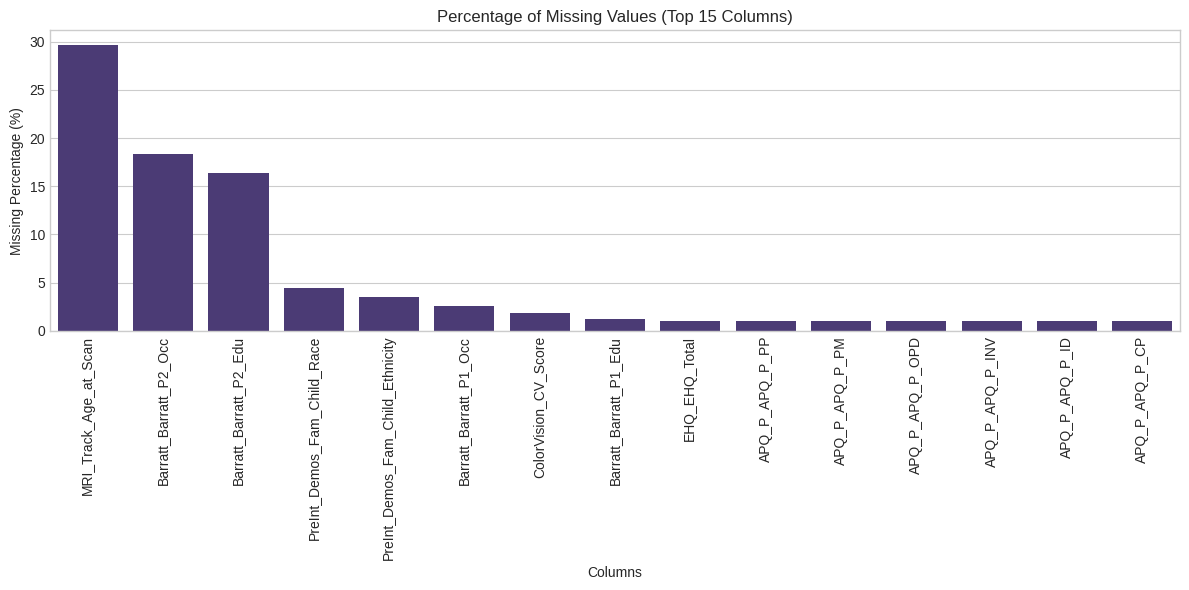

TARGET VARIABLE ANALYSIS: ADHD_Outcome

Target Distribution:
  • ADHD_Outcome=1: 831 instances (68.51%)
  • ADHD_Outcome=0: 382 instances (31.49%)

Class imbalance ratio (majority:minority): 2.18:1


<ipython-input-8-1cfe4d409dde>:152: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=target_col, data=df, palette='viridis')


Figure saved to: /content/adhd_eda_visualizations/ADHD_Outcome_distribution.png


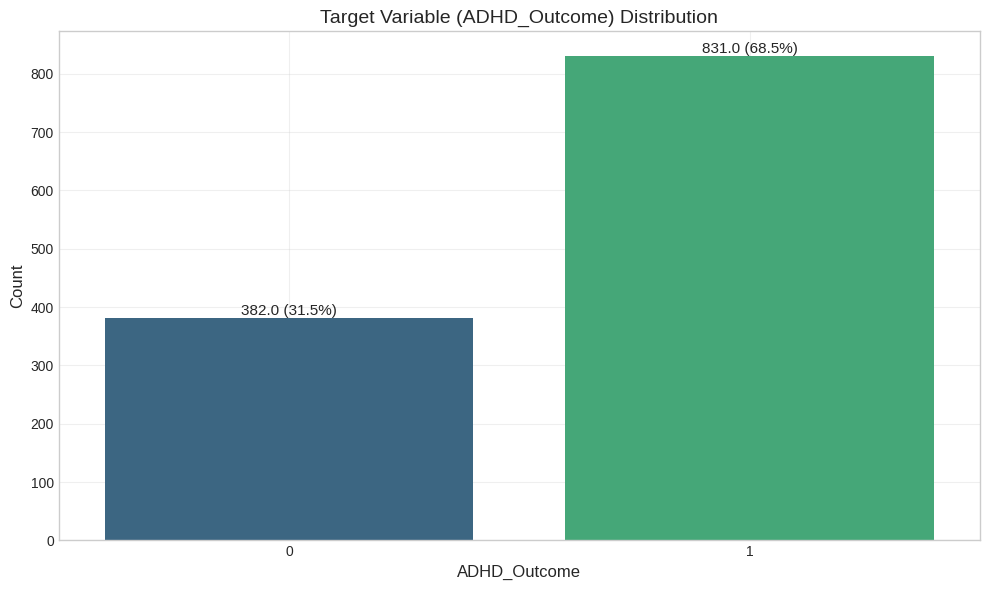

CORRELATION ANALYSIS

Top features correlated with target:
SDQ_SDQ_Hyperactivity         0.558625
SDQ_SDQ_Externalizing         0.514630
SDQ_SDQ_Difficulties_Total    0.464724
SDQ_SDQ_Generating_Impact     0.410349
SDQ_SDQ_Conduct_Problems      0.275598
SDQ_SDQ_Internalizing         0.257269
SDQ_SDQ_Peer_Problems         0.219253
SDQ_SDQ_Emotional_Problems    0.205459
SDQ_SDQ_Prosocial             0.190466
Basic_Demos_Enroll_Year       0.166252
dtype: float64
Figure saved to: /content/adhd_eda_visualizations/top_15_correlations.png


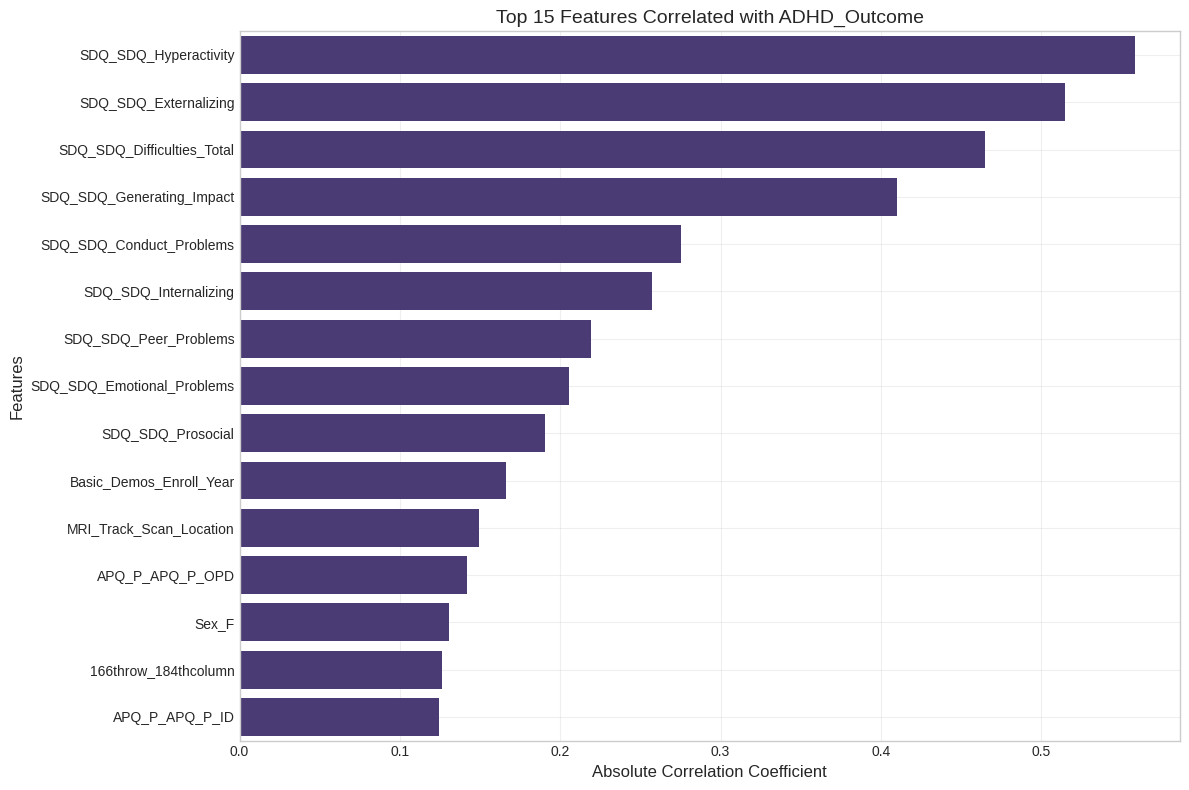

Figure saved to: /content/adhd_eda_visualizations/correlation_heatmap.png


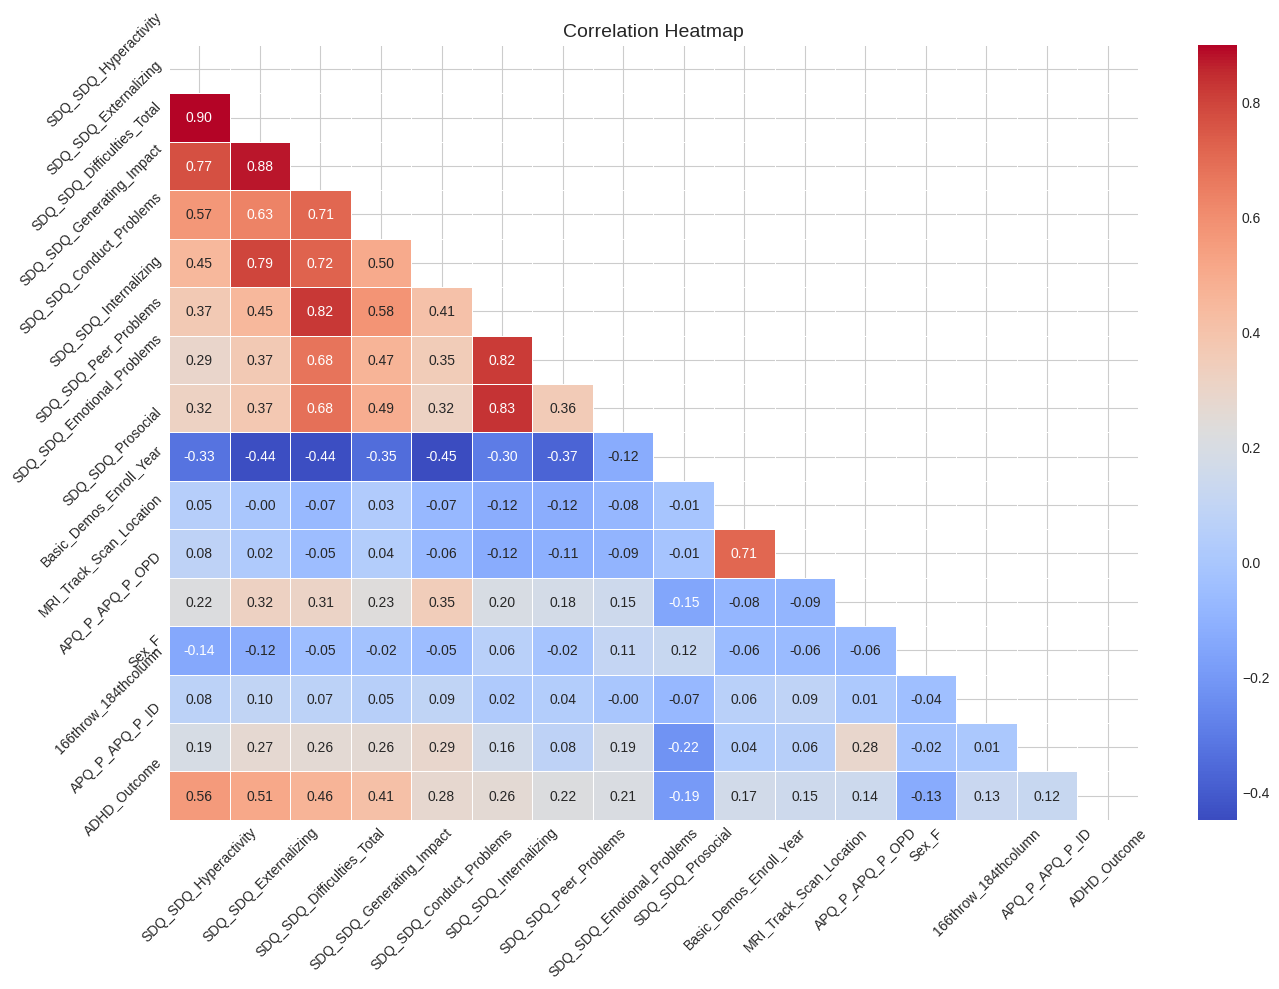

Figure saved to: /content/adhd_eda_visualizations/feature_distributions.png


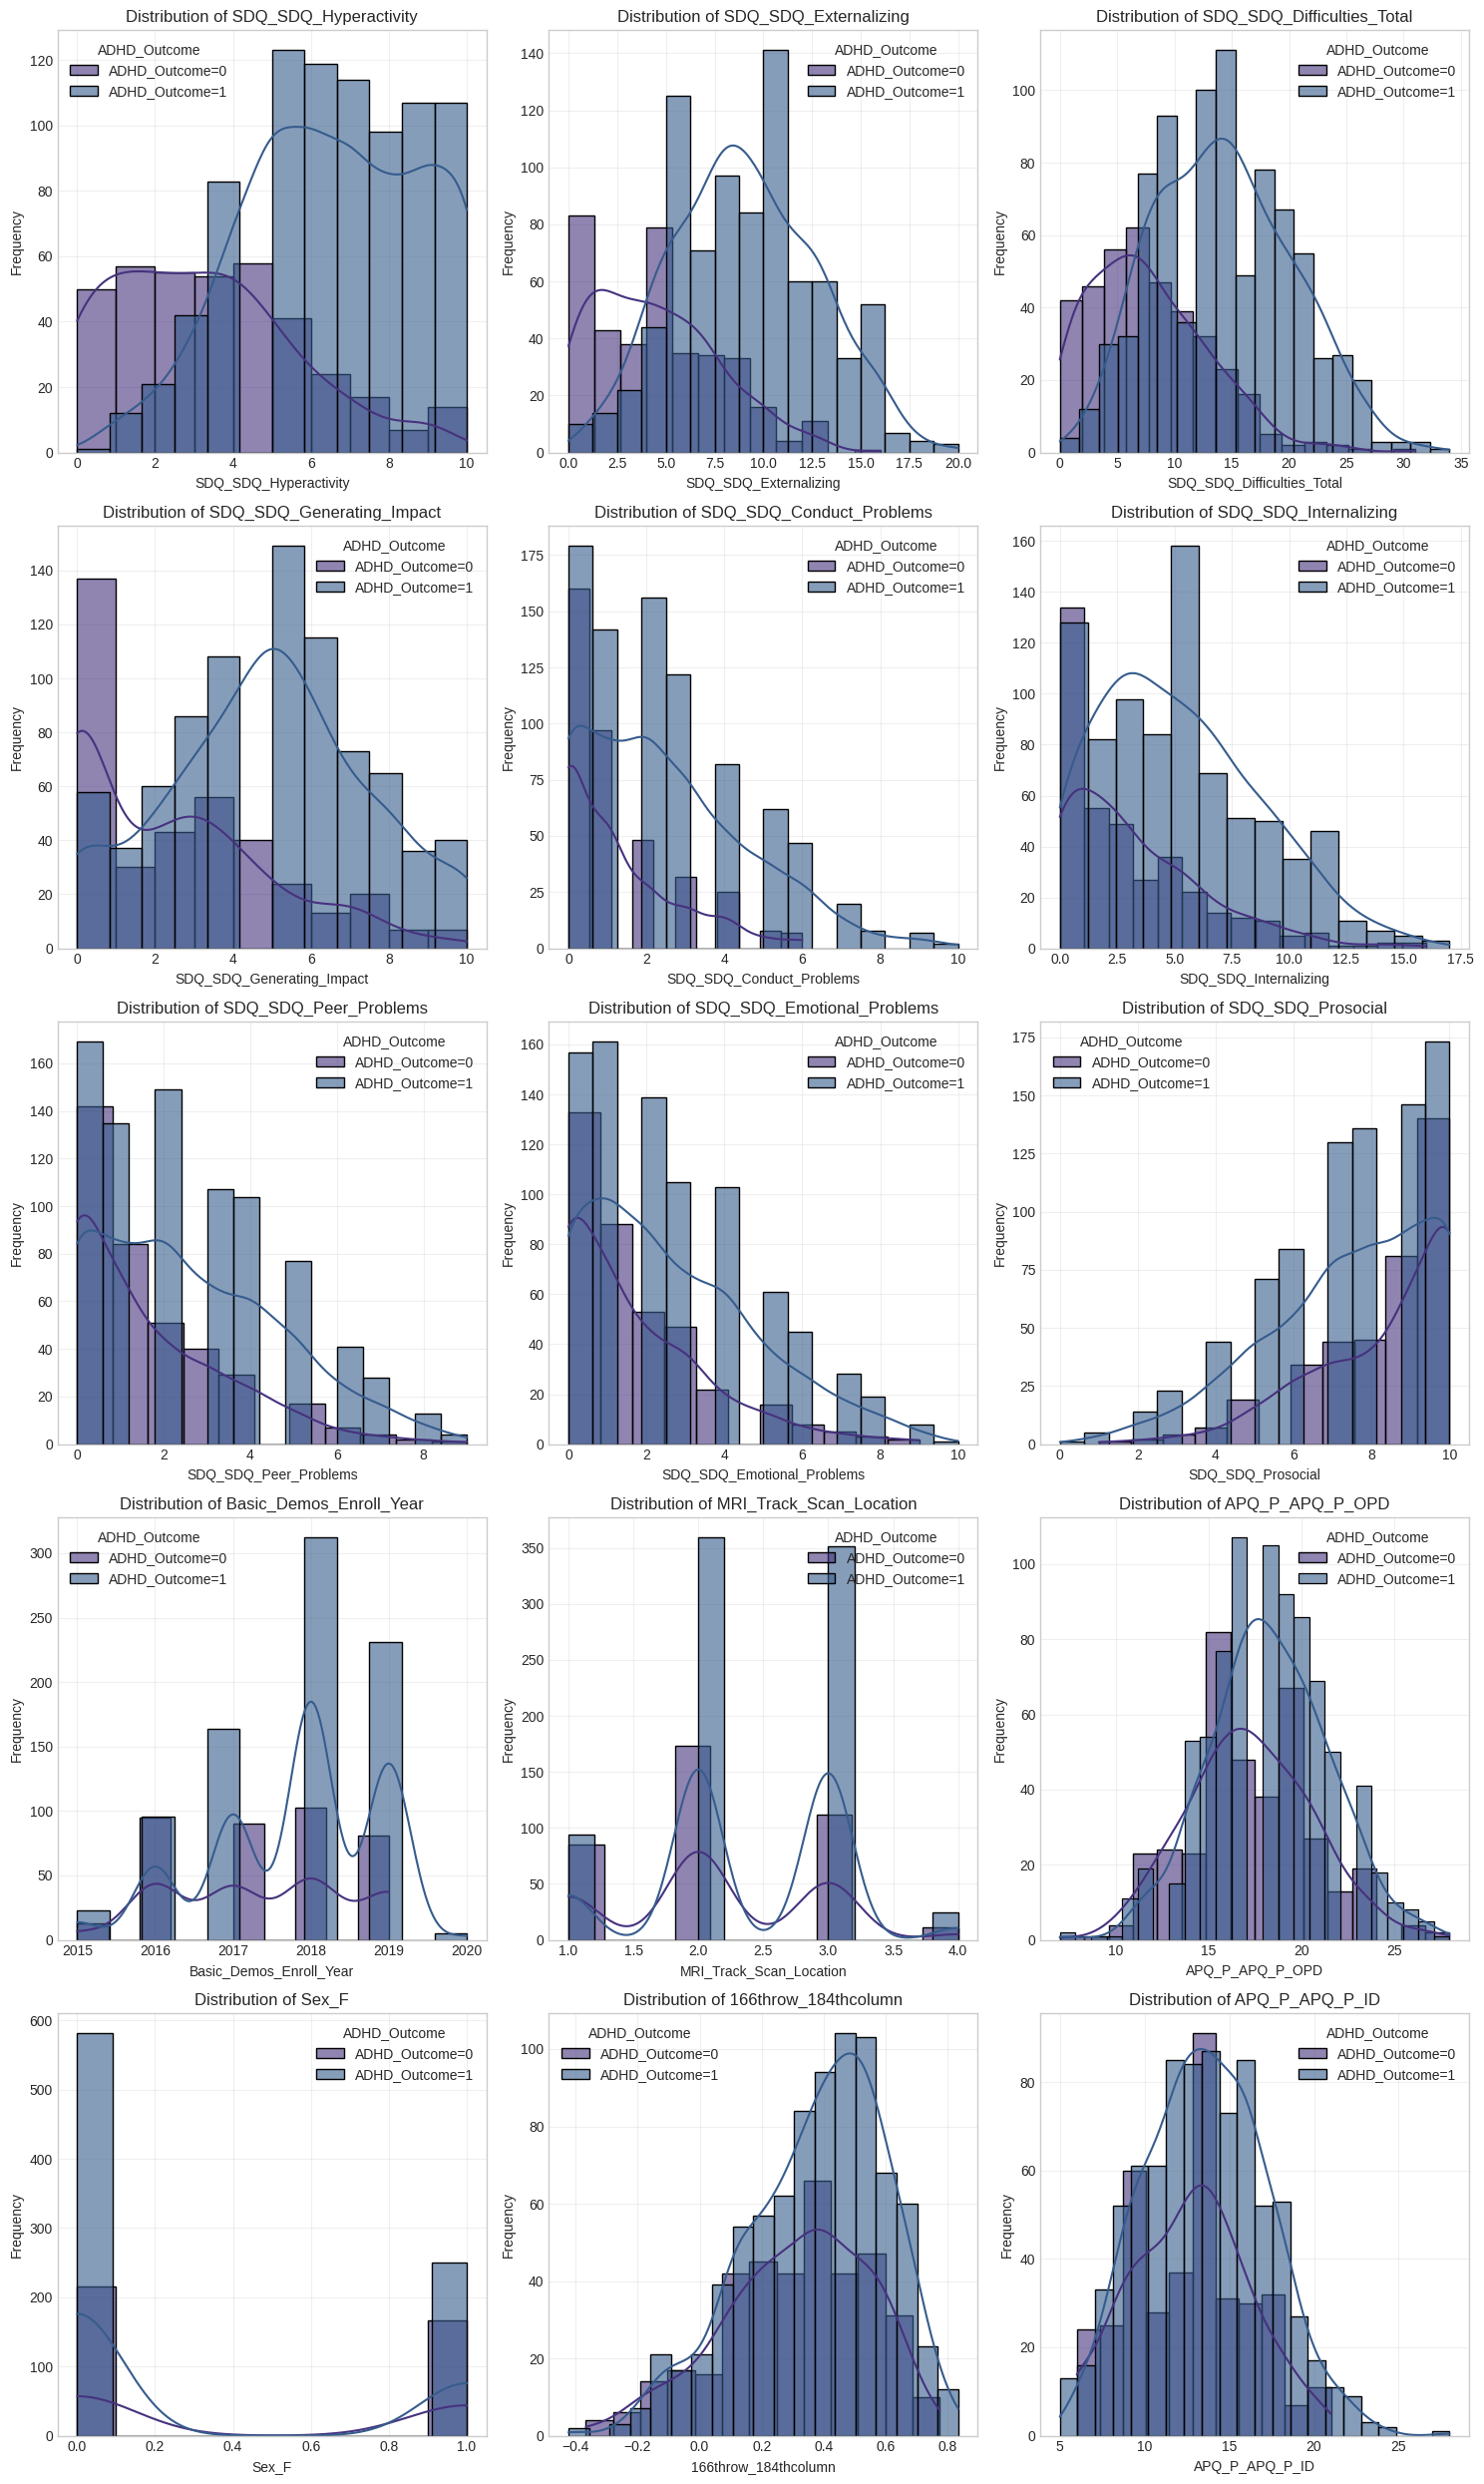

BIVARIATE ANALYSIS
Figure saved to: /content/adhd_eda_visualizations/bivariate_analysis.png


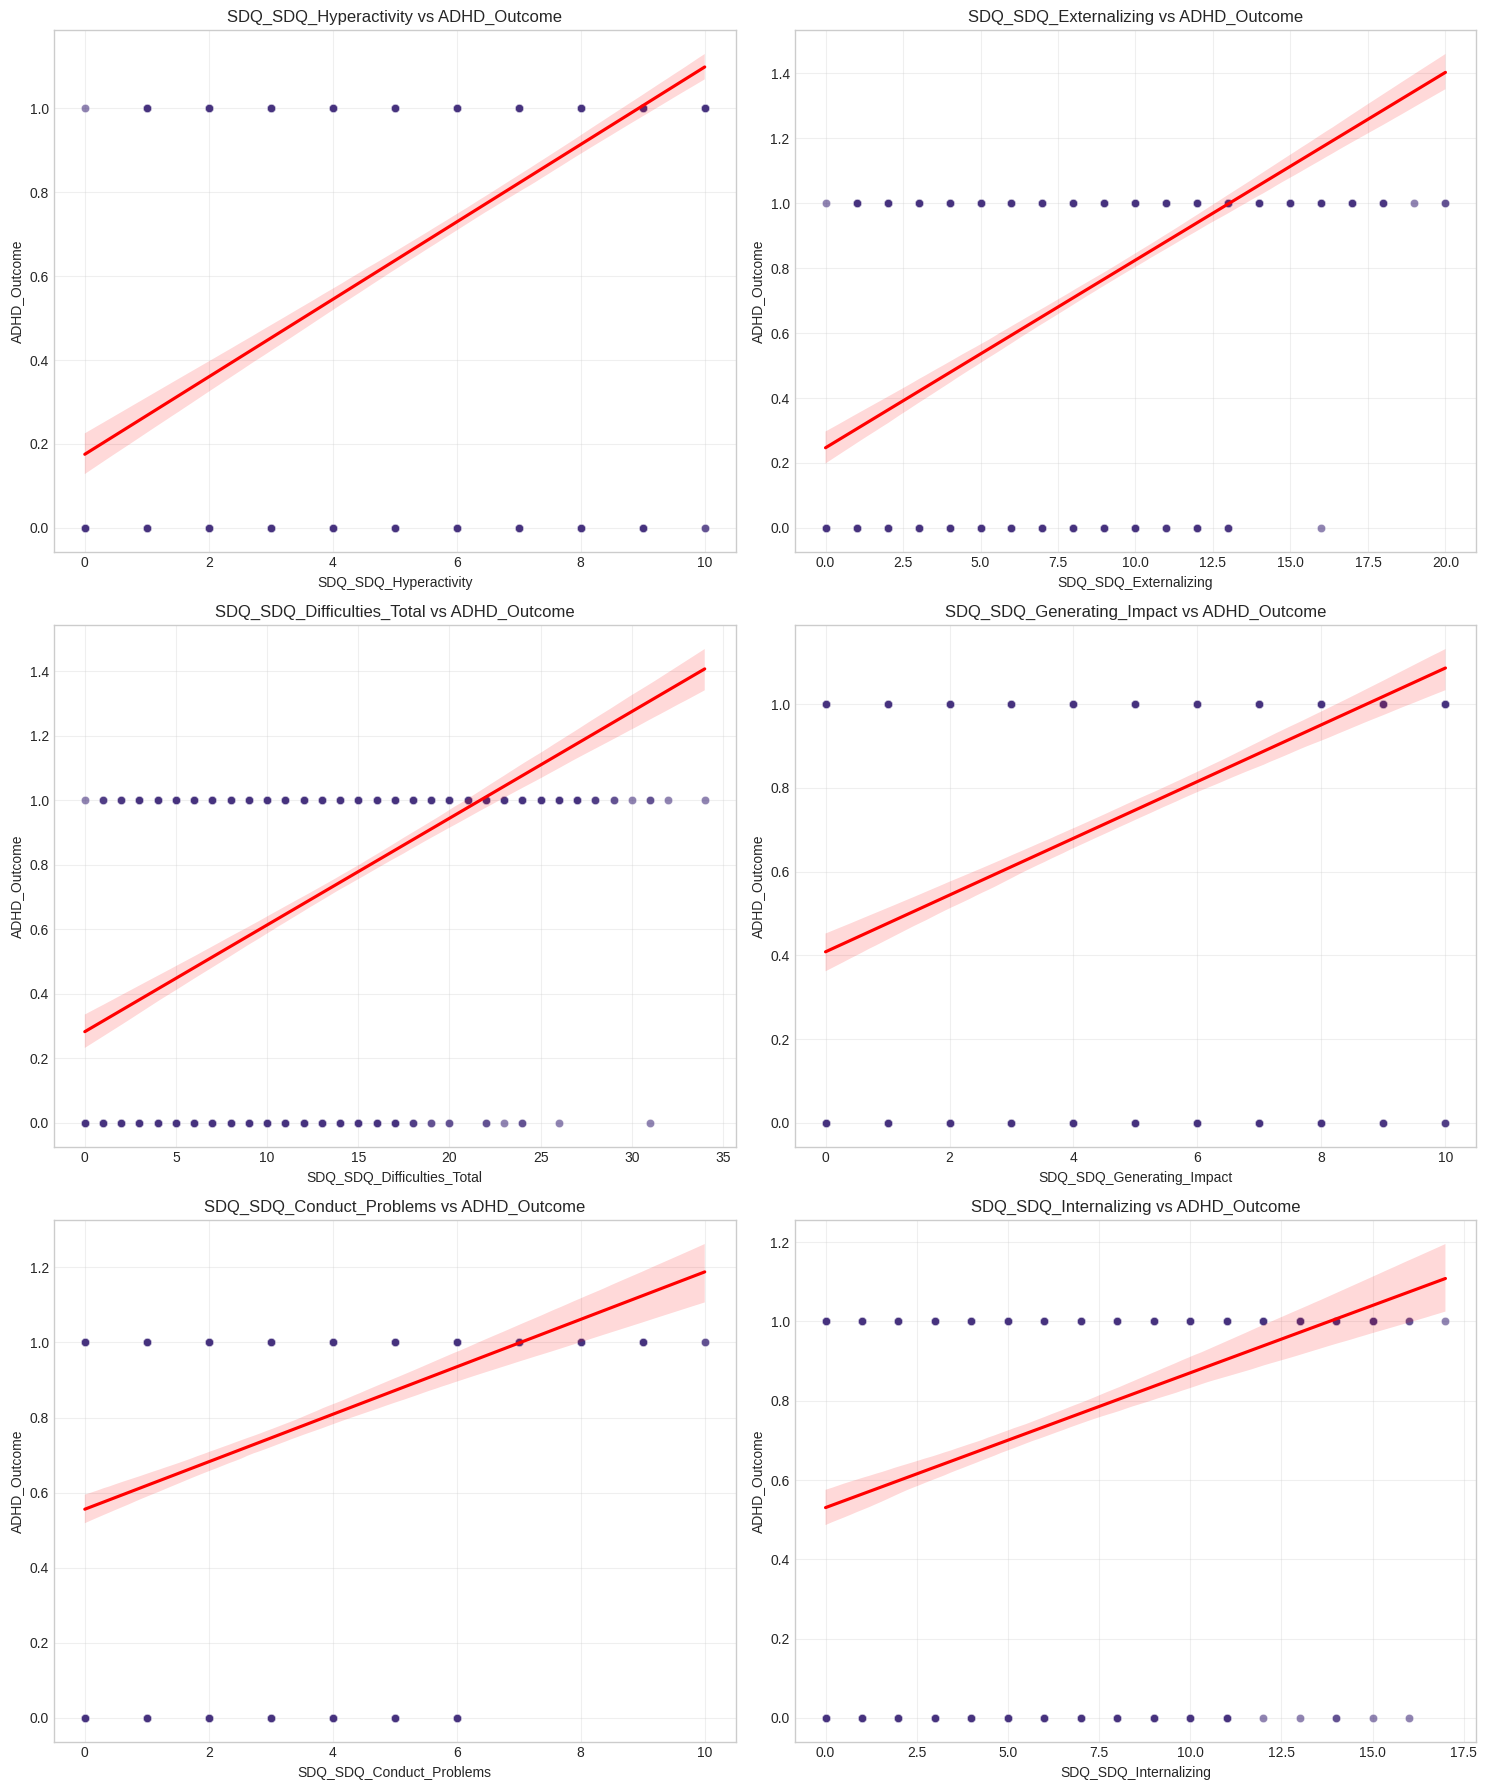

OUTLIER ANALYSIS
Limiting outlier analysis to first 10 of 15 features.
Figure saved to: /content/adhd_eda_visualizations/outlier_boxplot.png


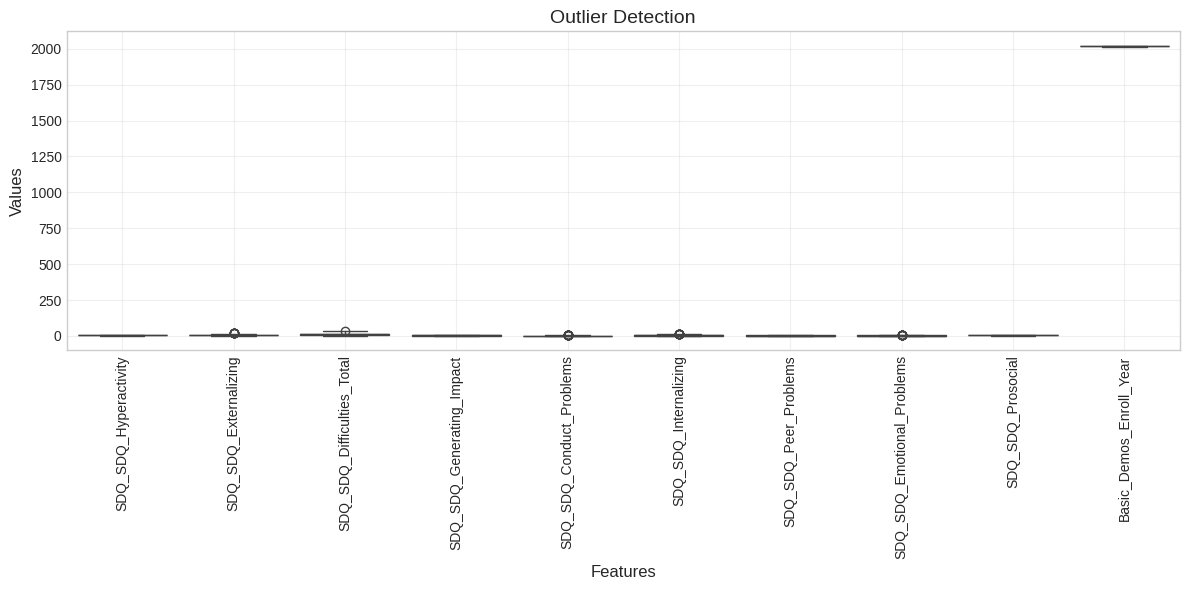


Features with highest outlier percentages:
  • SDQ_SDQ_Conduct_Problems: 17 outliers (1.40%)
  • SDQ_SDQ_Emotional_Problems: 11 outliers (0.91%)
  • SDQ_SDQ_Internalizing: 10 outliers (0.82%)
  • SDQ_SDQ_Externalizing: 7 outliers (0.58%)
  • SDQ_SDQ_Difficulties_Total: 1 outliers (0.08%)
PCA ANALYSIS
Figure saved to: /content/adhd_eda_visualizations/pca_variance.png


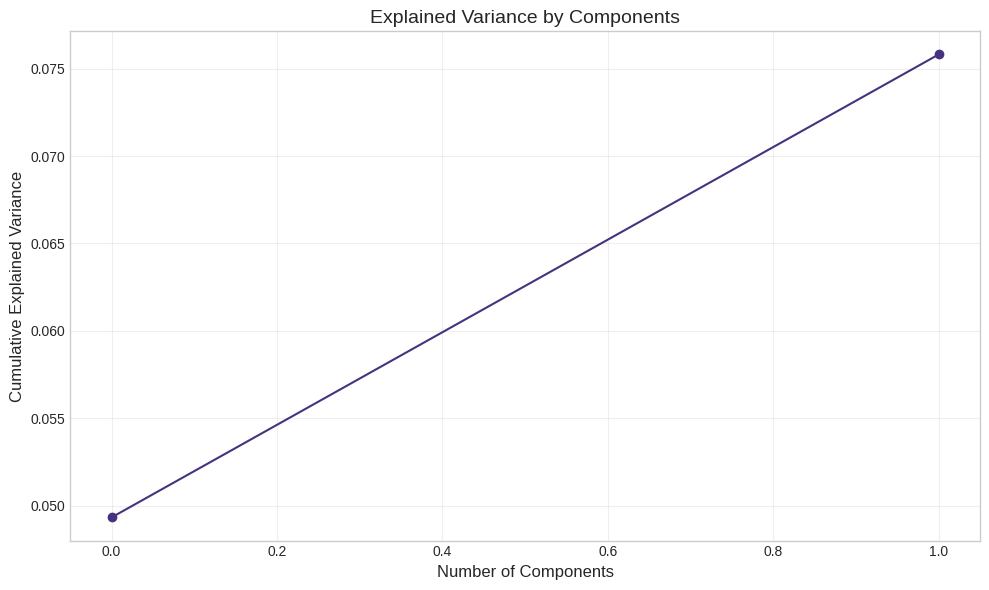

Figure saved to: /content/adhd_eda_visualizations/pca_scatter.png


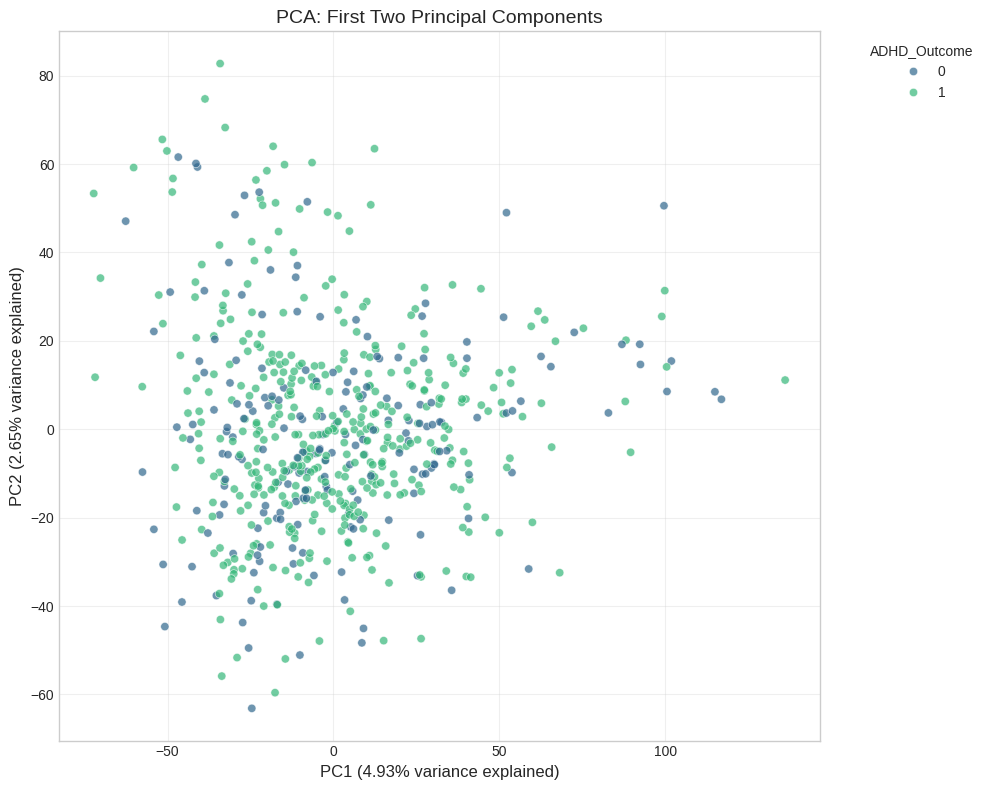

Figure saved to: /content/adhd_eda_visualizations/pca_loadings.png


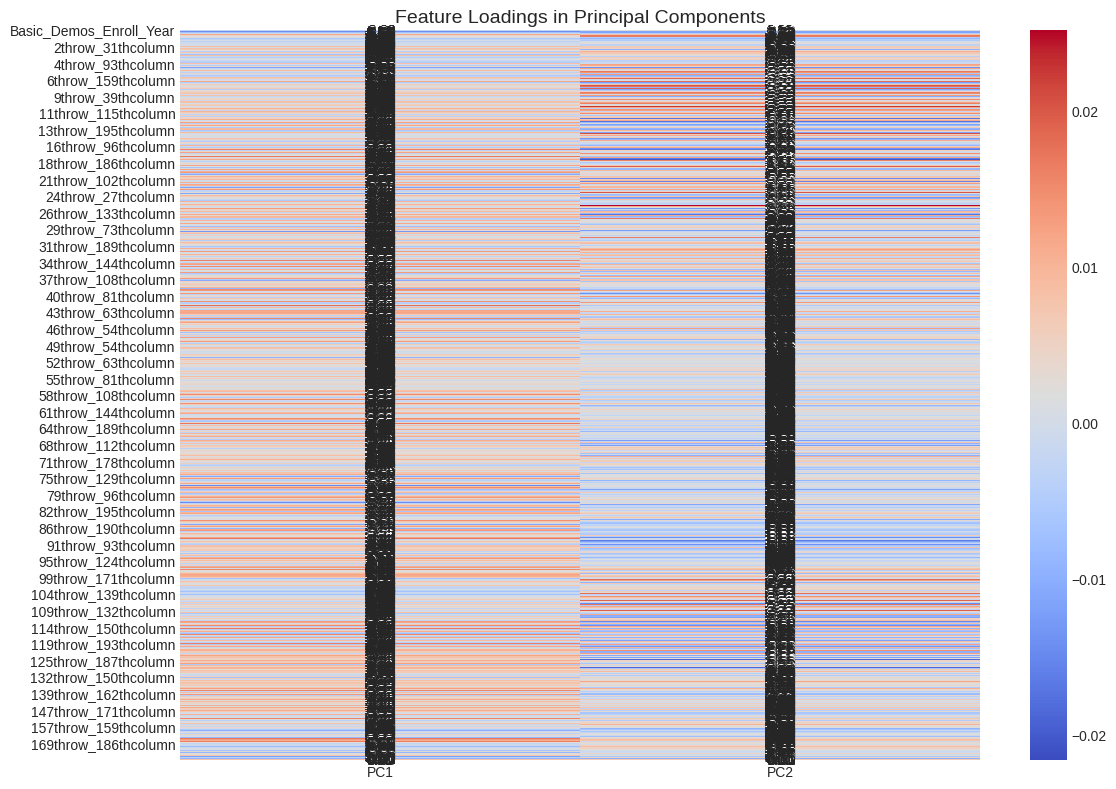

EDA COMPLETED SUCCESSFULLY
All visualizations saved to: /content/adhd_eda_visualizations

Performing additional targeted analyses...
CORRELATION ANALYSIS

Top features correlated with target:
SDQ_SDQ_Hyperactivity         0.558625
SDQ_SDQ_Externalizing         0.514630
SDQ_SDQ_Difficulties_Total    0.464724
SDQ_SDQ_Generating_Impact     0.410349
SDQ_SDQ_Conduct_Problems      0.275598
SDQ_SDQ_Internalizing         0.257269
SDQ_SDQ_Peer_Problems         0.219253
SDQ_SDQ_Emotional_Problems    0.205459
SDQ_SDQ_Prosocial             0.190466
Basic_Demos_Enroll_Year       0.166252
dtype: float64
Figure saved to: /content/adhd_eda_visualizations/top_5_correlations.png


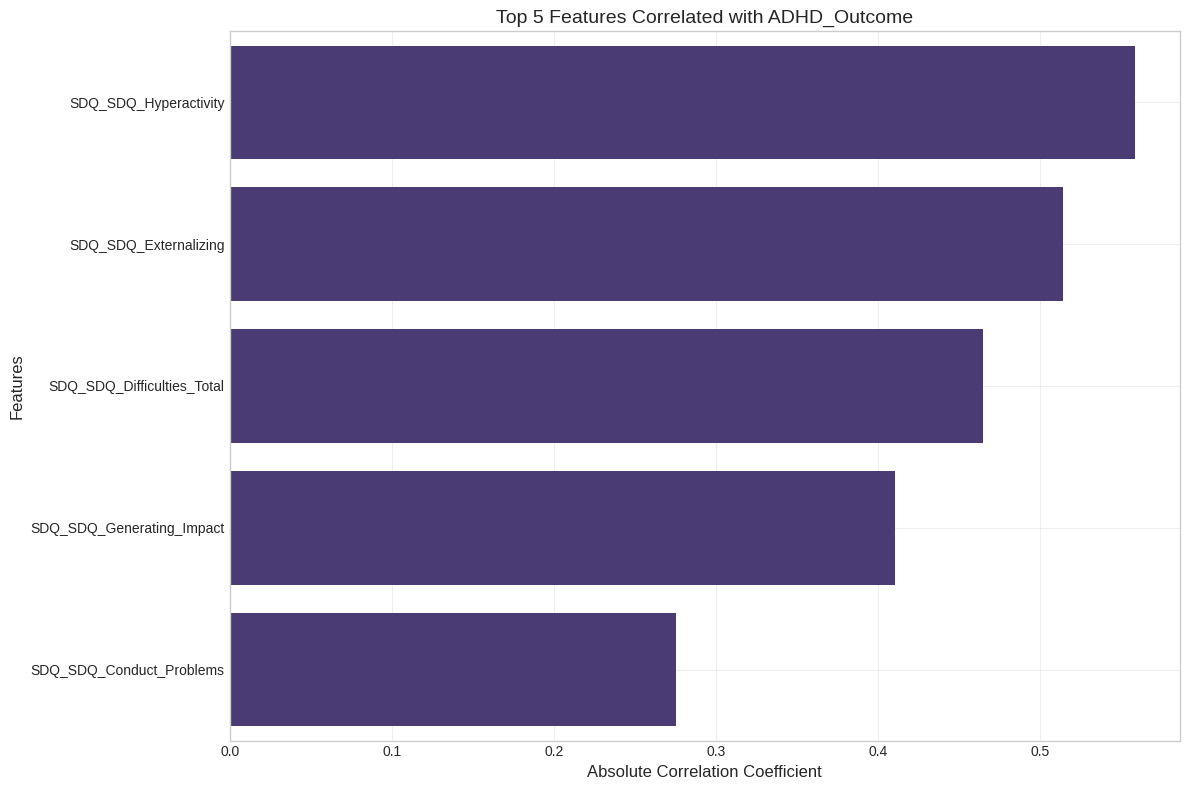

Figure saved to: /content/adhd_eda_visualizations/correlation_heatmap.png


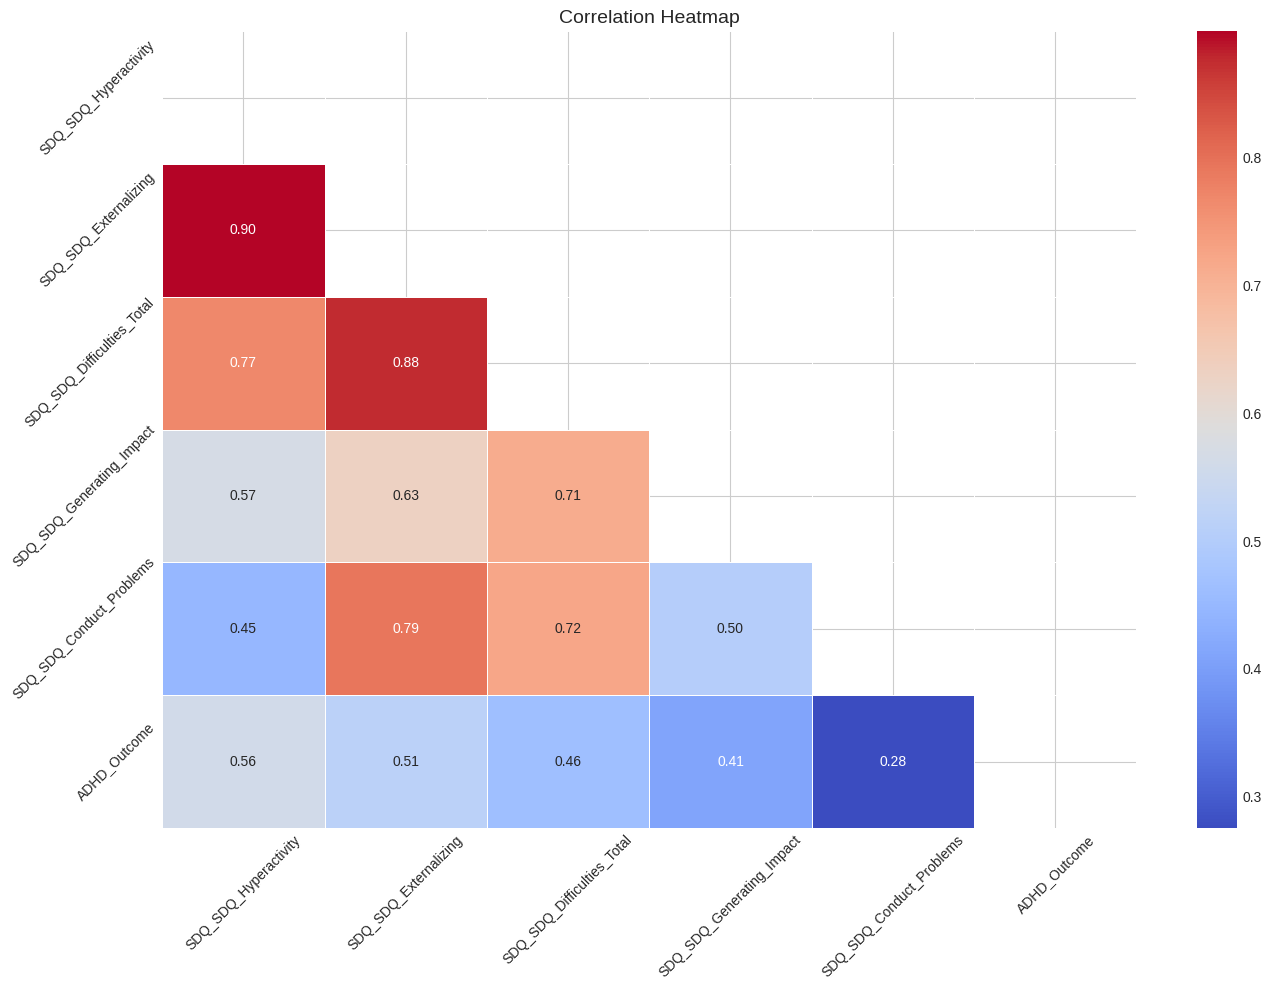


Comparing train vs test distributions for top features...
Figure saved to: /content/adhd_eda_visualizations/SDQ_SDQ_Hyperactivity_train_test_comparison.png


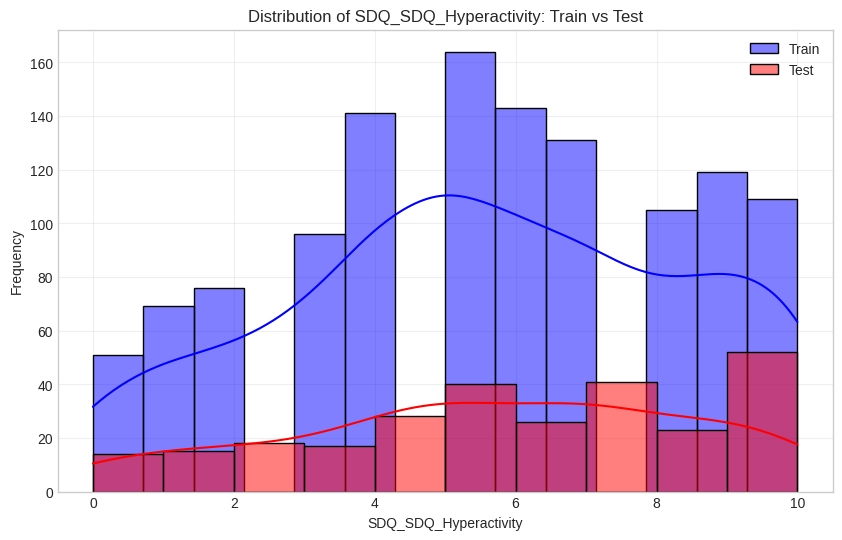

Figure saved to: /content/adhd_eda_visualizations/SDQ_SDQ_Externalizing_train_test_comparison.png


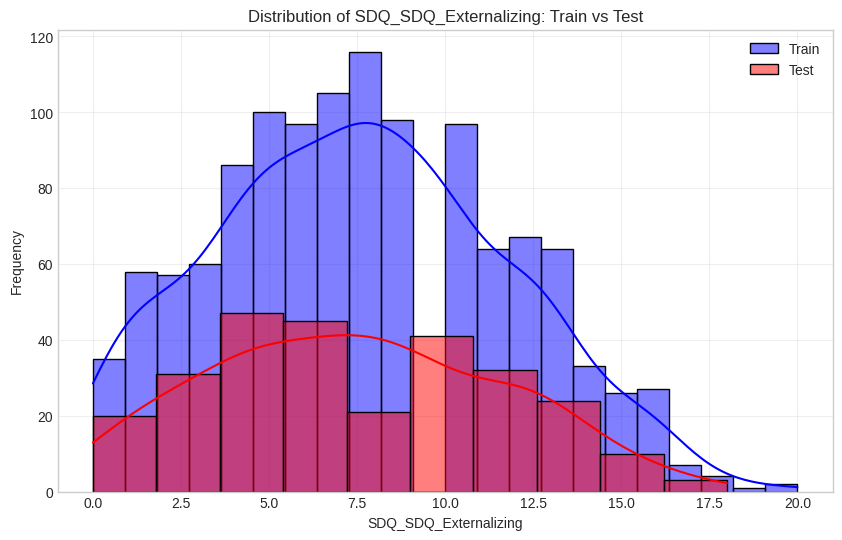

Figure saved to: /content/adhd_eda_visualizations/SDQ_SDQ_Difficulties_Total_train_test_comparison.png


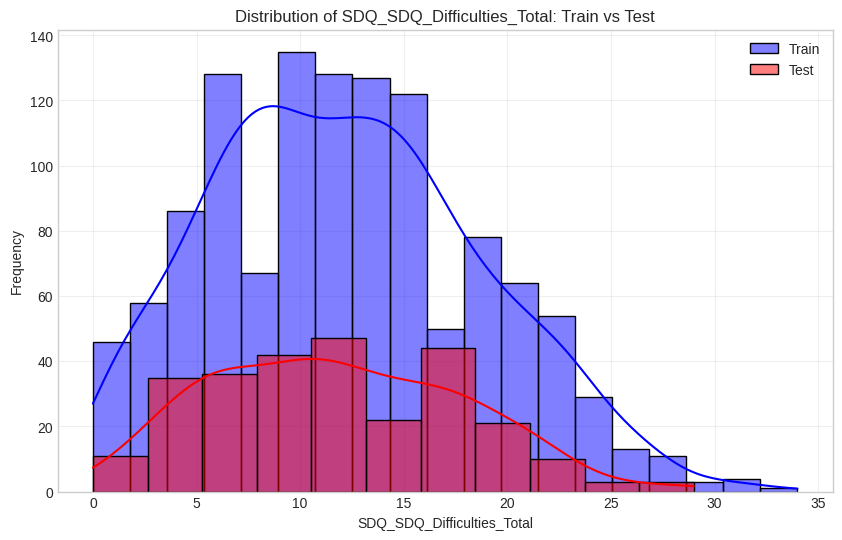

Figure saved to: /content/adhd_eda_visualizations/SDQ_SDQ_Generating_Impact_train_test_comparison.png


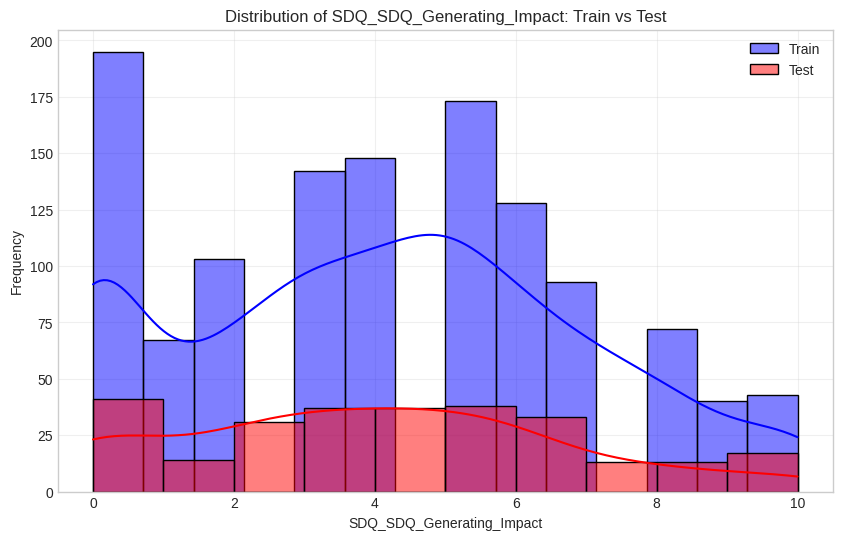

Figure saved to: /content/adhd_eda_visualizations/SDQ_SDQ_Conduct_Problems_train_test_comparison.png


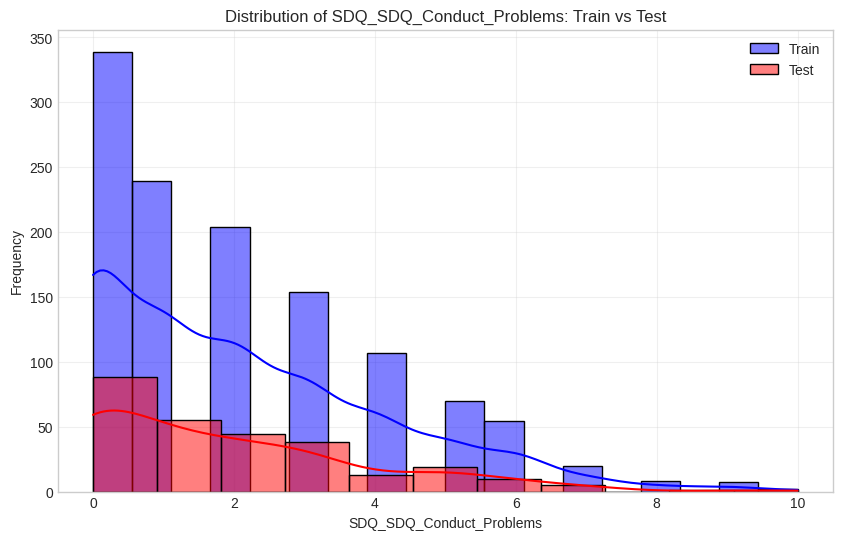


Analyzing SDQ features specifically relevant to ADHD...
Figure saved to: /content/adhd_eda_visualizations/sdq_features_by_adhd.png


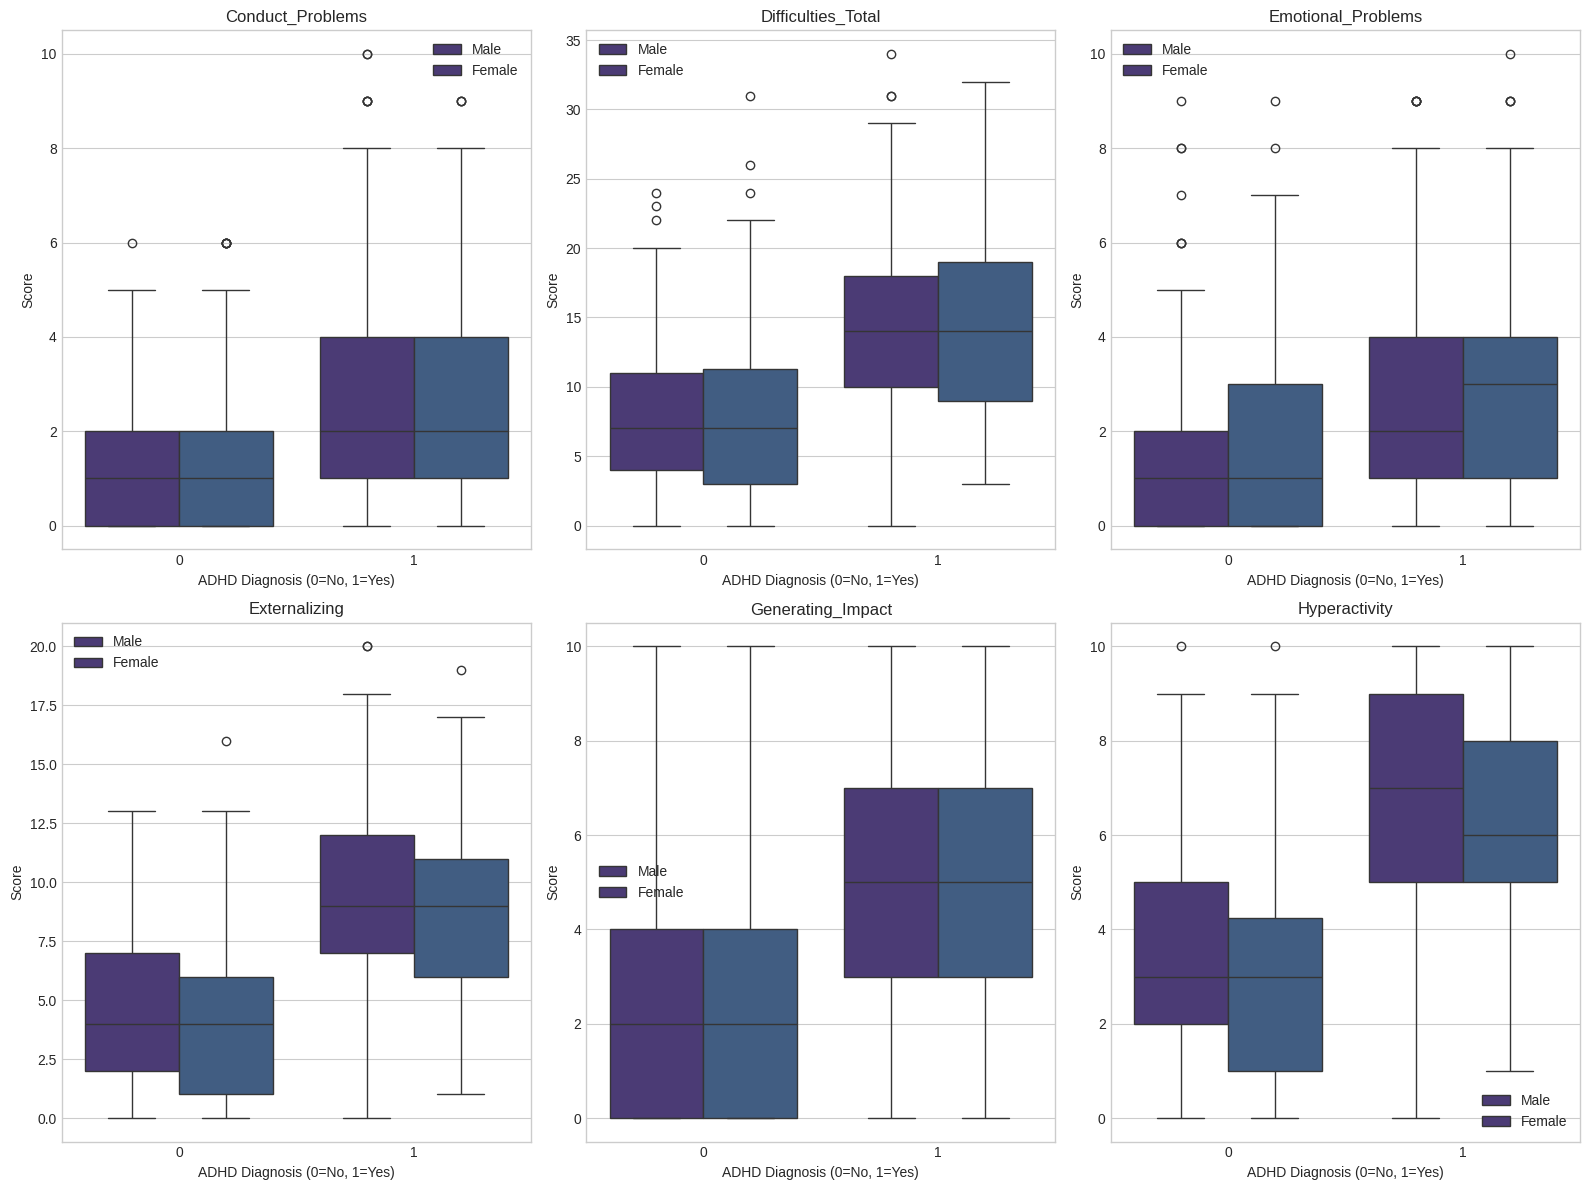


ADHD EDA process completed successfully.
All visualizations saved to: /content/adhd_eda_visualizations
  adding: content/adhd_eda_visualizations/ (stored 0%)
  adding: content/adhd_eda_visualizations/sdq_features_by_adhd.png (deflated 32%)
  adding: content/adhd_eda_visualizations/pca_variance.png (deflated 20%)
  adding: content/adhd_eda_visualizations/SDQ_SDQ_Generating_Impact_train_test_comparison.png (deflated 15%)
  adding: content/adhd_eda_visualizations/missing_values.png (deflated 22%)
  adding: content/adhd_eda_visualizations/outlier_boxplot.png (deflated 22%)
  adding: content/adhd_eda_visualizations/bivariate_analysis.png (deflated 19%)
  adding: content/adhd_eda_visualizations/feature_distributions.png (deflated 11%)
  adding: content/adhd_eda_visualizations/pca_scatter.png (deflated 7%)
  adding: content/adhd_eda_visualizations/correlation_heatmap.png (deflated 21%)
  adding: content/adhd_eda_visualizations/SDQ_SDQ_Difficulties_Total_train_test_comparison.png (deflated 13

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Visualization ZIP file ready for download!


In [ ]:

train_file = train
test_file = test

#Run the EDA
run_adhd_eda_colab(train, test)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve, auc
)
from sklearn.inspection import PartialDependenceDisplay
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import shap
import warnings
import os
import time
from datetime import datetime

In [ ]:
# Ignore warnings
warnings.filterwarnings('ignore')

# Create a directory for saving plots
os.makedirs('plots', exist_ok=True)

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Start time for performance tracking
start_time = time.time()

def feature_engineering(df):
    """
    Perform feature engineering on the input dataframe.

    Args:
        df (pandas.DataFrame): Input dataframe

    Returns:
        pandas.DataFrame: Dataframe with engineered features
    """
    print("Performing feature engineering...")
    # Create copy to avoid SettingWithCopyWarning
    df = df.copy()

    # 1. Handle Missing Values First
    numeric_cols = df.select_dtypes(include=np.number).columns
    df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

    # 2. Feature Interactions
    if all(col in df.columns for col in ['Age', 'FD_mean']):
        df['Age_FD_interaction'] = df['Age'] * df['FD_mean']
        print("- Created Age_FD_interaction feature")

    # 3. Optimized Polynomial Features
    if 'FD_mean' in df.columns:
        fd_mean = df['FD_mean'].values
        df['FD_mean_squared'] = np.square(fd_mean)
        df['FD_mean_cubed'] = np.power(fd_mean, 3)
        print("- Created polynomial features from FD_mean")

    # 4. Efficient Binning
    if 'Age' in df.columns:
        df['Age_binned'] = pd.qcut(df['Age'], q=5, labels=False, duplicates='drop')
        print("- Created Age_binned feature")

    # 5. Statistical Features with NaN handling
    if 'FD_mean' in df.columns:
        df['FD_mean_rolling_std'] = df['FD_mean'].rolling(window=3, min_periods=1).std()
        print("- Created rolling statistics feature")

    # 6. Cluster Features with Safe Initialization
    if len(numeric_cols) > 3:
        # Select features with least missing values
        cluster_feats = df[numeric_cols].isna().sum().nsmallest(5).index.tolist()

        # Ensure no NaNs remain
        cluster_data = df[cluster_feats].fillna(df[cluster_feats].median())

        # Only cluster if we have enough data
        if len(cluster_data) > 10:
            try:
                from sklearn.cluster import KMeans
                kmeans = KMeans(n_clusters=3, random_state=RANDOM_STATE, n_init=10)
                df['cluster'] = kmeans.fit_predict(cluster_data)
                print("- Created cluster feature")
            except Exception as e:
                print(f"Clustering failed: {str(e)}")
                df['cluster'] = 0  # Default cluster if fails

    # 7. Time-Based Features (optimized)
    if 'session_id' in df.columns and 'participant_id' in df.columns:
        df['session_count'] = df.groupby('participant_id')['session_id'].transform('nunique')
        print("- Created session count feature")

    print(f"Feature engineering completed. Dataframe now has {df.shape[1]} columns.")
    return df

In [ ]:
def preprocess_data(train, test, target_col="ADHD_Outcome"):
    """
    Preprocess the training and test data for model training.

    Args:
        train (pandas.DataFrame): Training dataframe
        test (pandas.DataFrame): Test dataframe
        target_col (str): Name of the target column

    Returns:
        tuple: Processed data (X, test_X, y, selected_features)
    """
    print("\nPreprocessing data...")

    # Separate features and target
    columns_to_drop = ["participant_id", "ADHD_Outcome",
                      "Sex_F", "data_source"]

    # Only drop columns that exist
    columns_to_drop = [col for col in columns_to_drop if col in train.columns]

    y = train[target_col] if target_col in train.columns else None
    if y is None:
        print(f"Target column '{target_col}' not found. Available columns: {train.columns.tolist()}")
        raise ValueError(f"Target column '{target_col}' not found in training data")

    X = train.drop(columns=columns_to_drop, errors='ignore')

    # Drop the same columns from test data if they exist
    test_cols_to_drop = [col for col in ["participant_id", "data_source"] if col in test.columns]
    test_X = test.drop(columns=test_cols_to_drop, errors='ignore')

    # Identify feature types
    num_cols = X.select_dtypes(include=np.number).columns.tolist()
    cat_cols = X.select_dtypes(include=['object']).columns.tolist()

    print(f"- Numeric features: {len(num_cols)}")
    print(f"- Categorical features: {len(cat_cols)}")

    # Preprocessing pipelines
    num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('transformer', PowerTransformer(method='yeo-johnson'))
    ])

    # Update cat_pipeline to use OneHotEncoder instead of LabelEncoder for proper handling
    cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', LabelEncoder())  # LabelEncoder for simplicity, but typically OneHotEncoder is better
    ])

    # Create column transformer for preprocessing
    transformers = []
    if num_cols:
        transformers.append(('num', num_pipeline, num_cols))
    if cat_cols:
        transformers.append(('cat', cat_pipeline, cat_cols))

    preprocessor = ColumnTransformer(transformers)

    # Apply preprocessing
    X_processed = preprocessor.fit_transform(X)
    test_processed = preprocessor.transform(test_X)

    print(f"- Data preprocessed. Training shape: {X_processed.shape}")

    # Feature Selection
    selector = SelectKBest(score_func=f_classif, k=min(30, X_processed.shape[1]))
    X_selected = selector.fit_transform(X_processed, y)
    test_selected = selector.transform(test_processed)

    # Get selected feature names (combining numeric and categorical features)
    feature_names = np.array(num_cols + cat_cols)
    selected_features = feature_names[selector.get_support()] if len(feature_names) == X_processed.shape[1] else None

    if selected_features is not None:
        print(f"- Selected top {len(selected_features)} features")
    else:
        print(f"- Selected {X_selected.shape[1]} features (names unavailable)")

    print("Preprocessing completed")
    return X_selected, test_selected, y, selected_features

In [ ]:
def apply_pca(X, test_X, min_variance=0.95):
    """
    Apply PCA dimensionality reduction.

    Args:
        X (numpy.ndarray): Training data
        test_X (numpy.ndarray): Test data
        min_variance (float): Minimum variance to preserve

    Returns:
        tuple: PCA-transformed data (X_pca, test_X_pca, pca_model)
    """
    print("\nApplying PCA dimensionality reduction...")
    pca = PCA(n_components=min_variance, random_state=RANDOM_STATE)
    X_pca = pca.fit_transform(X)
    test_X_pca = pca.transform(test_X)

    print(f"- Original Features: {X.shape[1]}")
    print(f"- PCA Reduced Features: {X_pca.shape[1]}")
    print(f"- Explained Variance: {pca.explained_variance_ratio_.sum():.2f}")

    # Plot explained variance
    plt.figure(figsize=(10, 6))
    plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('PCA Explained Variance')
    plt.grid(True)
    plt.savefig('plots/pca_variance.png', dpi=300, bbox_inches='tight')

    return X_pca, test_X_pca, pca

In [ ]:
def split_data(X, y, test_size=0.2):
    """
    Split data into training and testing sets.

    Args:
        X (numpy.ndarray): Feature matrix
        y (numpy.ndarray): Target vector
        test_size (float): Proportion of data to use for testing

    Returns:
        tuple: X_train, X_test, y_train, y_test
    """
    print(f"\nSplitting data into training ({1-test_size:.0%}) and testing ({test_size:.0%}) sets...")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=RANDOM_STATE, stratify=y
    )
    print(f"- Training set: {X_train.shape[0]} samples")
    print(f"- Testing set: {X_test.shape[0]} samples")
    return X_train, X_test, y_train, y_test

In [ ]:
def evaluate_models(X, y, cv=StratifiedKFold(n_splits=5)):
    """
    Evaluate multiple classification models using cross-validation.

    Args:
        X (numpy.ndarray): Feature matrix
        y (numpy.ndarray): Target vector
        cv (cross-validation generator): Cross-validation strategy

    Returns:
        dict: Dictionary of model results
    """
    print("\nEvaluating models with cross-validation...")

    # Define models to evaluate
    models = {
        'Random Forest': RandomForestClassifier(random_state=RANDOM_STATE),
        'XGBoost': XGBClassifier(random_state=RANDOM_STATE, eval_metric='logloss'),
        'LightGBM': LGBMClassifier(random_state=RANDOM_STATE),
        'SVM': SVC(probability=True, random_state=RANDOM_STATE),
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
        'MLP': MLPClassifier(random_state=RANDOM_STATE, max_iter=1000),
        'AdaBoost': AdaBoostClassifier(random_state=RANDOM_STATE)
    }

    # Initialize results dictionary
    results = {}

    # Metrics to evaluate
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

    # Evaluate each model
    for name, model in models.items():
        print(f"\nEvaluating: {name}")
        model_results = {}

        # Create pipeline with standardization
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', model)
        ])

        # Calculate cross-validation scores for each metric
        for metric in metrics:
            try:
                cv_scores = cross_val_score(pipeline, X, y, cv=cv, scoring=metric)
                model_results[metric] = {
                    'mean': cv_scores.mean(),
                    'std': cv_scores.std()
                }
                print(f"- {metric.upper()}: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
            except Exception as e:
                print(f"- Error calculating {metric}: {str(e)}")
                model_results[metric] = {'mean': 0, 'std': 0}

        # Store results
        results[name] = model_results

    # Print summary of best models by ROC AUC
    print("\nModel Ranking by ROC AUC:")
    sorted_models = sorted(
        [(name, results[name]['roc_auc']['mean']) for name in results],
        key=lambda x: x[1],
        reverse=True
    )

    for i, (name, score) in enumerate(sorted_models):
        print(f"{i+1}. {name}: {score:.4f}")

    return results

In [ ]:
def tune_hyperparameters(X, y, models_to_tune):
    """
    Tune hyperparameters for specified models.

    Args:
        X (numpy.ndarray): Feature matrix
        y (numpy.ndarray): Target vector
        models_to_tune (list): List of model names to tune

    Returns:
        dict: Dictionary of tuned models
    """
    print("\nTuning hyperparameters for selected models...")

    # Define parameter grids for each model
    param_grids = {
        'Random Forest': {
            'model__n_estimators': [100, 200, 300],
            'model__max_depth': [3, 5, 7, 10, None],
            'model__min_samples_split': [2, 5, 10],
            'model__min_samples_leaf': [1, 2, 4]
        },
        'XGBoost': {
            'model__n_estimators': [100, 200, 300],
            'model__max_depth': [3, 5, 7],
            'model__learning_rate': [0.01, 0.05, 0.1],
            'model__subsample': [0.8, 0.9, 1.0],
            'model__colsample_bytree': [0.8, 0.9, 1.0]
        },
        'LightGBM': {
            'model__n_estimators': [100, 200, 300],
            'model__max_depth': [3, 5, 7, -1],
            'model__learning_rate': [0.01, 0.05, 0.1],
            'model__num_leaves': [31, 50, 70]
        },
        'SVM': {
            'model__C': [0.1, 1, 10, 100],
            'model__gamma': ['scale', 'auto', 0.1, 0.01],
            'model__kernel': ['rbf', 'linear', 'poly']
        },
        'Logistic Regression': {
            'model__C': [0.01, 0.1, 1, 10, 100],
            'model__penalty': ['l1', 'l2', 'elasticnet', None],
            'model__solver': ['saga', 'liblinear']
        },
        'MLP': {
            'model__hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
            'model__activation': ['relu', 'tanh'],
            'model__alpha': [0.0001, 0.001, 0.01],
            'model__learning_rate': ['constant', 'adaptive']
        },
        'AdaBoost': {
            'model__n_estimators': [50, 100, 200],
            'model__learning_rate': [0.01, 0.1, 0.5, 1.0]
        }
    }

    # Define base models
    base_models = {
        'Random Forest': RandomForestClassifier(random_state=RANDOM_STATE),
        'XGBoost': XGBClassifier(random_state=RANDOM_STATE, eval_metric='logloss'),
        'LightGBM': LGBMClassifier(random_state=RANDOM_STATE),
        'SVM': SVC(probability=True, random_state=RANDOM_STATE),
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
        'MLP': MLPClassifier(random_state=RANDOM_STATE, max_iter=1000),
        'AdaBoost': AdaBoostClassifier(random_state=RANDOM_STATE)
    }

    # Initialize dictionary to store tuned models
    tuned_models = {}

    # Tune each specified model
    for model_name in models_to_tune:
        if model_name not in base_models:
            print(f"- Model '{model_name}' not found, skipping tuning")
            continue

        print(f"\nTuning {model_name}...")

        # Create pipeline with standardization
        model = base_models[model_name]
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', model)
        ])

        # Set up grid search
        grid_search = GridSearchCV(
            estimator=pipeline,
            param_grid=param_grids[model_name],
            cv=StratifiedKFold(n_splits=3),
            scoring='roc_auc',
            n_jobs=-1 if model_name != 'XGBoost' else 1,  # XGBoost can be unstable with n_jobs=-1
            verbose=1
        )

        # Fit grid search
        try:
            grid_search.fit(X, y)

            # Print best parameters and score
            print(f"- Best parameters: {grid_search.best_params_}")
            print(f"- Best ROC AUC: {grid_search.best_score_:.4f}")

            # Store best model
            tuned_models[model_name] = grid_search.best_estimator_

        except Exception as e:
            print(f"- Error tuning {model_name}: {str(e)}")

    print(f"\nTuned {len(tuned_models)} models")
    return tuned_models

In [ ]:
def plot_model_comparison(results, metric='roc_auc'):
    """
    Create a bar plot comparing model performance.

    Args:
        results (dict): Dictionary of model results
        metric (str): Metric to compare (default: 'roc_auc')
    """
    print(f"\nPlotting model comparison for {metric}...")

    # Extract model names and scores
    model_names = list(results.keys())
    scores = [results[model][metric]['mean'] for model in model_names]
    errors = [results[model][metric]['std'] for model in model_names]

    # Sort by performance
    sorted_indices = np.argsort(scores)
    sorted_model_names = [model_names[i] for i in sorted_indices]
    sorted_scores = [scores[i] for i in sorted_indices]
    sorted_errors = [errors[i] for i in sorted_indices]

    # Create bar plot
    plt.figure(figsize=(12, 8))
    bars = plt.barh(range(len(sorted_model_names)), sorted_scores, xerr=sorted_errors,
                   align='center', alpha=0.7, capsize=5)

    # Add value labels to the bars
    for i, bar in enumerate(bars):
        plt.text(bar.get_width() + sorted_errors[i] + 0.01, bar.get_y() + bar.get_height()/2,
                f'{sorted_scores[i]:.4f}', va='center')

    # Highlight best and worst models
    bars[0].set_color('lightcoral')  # Worst model
    bars[-1].set_color('lightgreen')  # Best model

    # Add labels and title
    plt.yticks(range(len(sorted_model_names)), sorted_model_names)
    plt.xlabel(f'{metric.upper()} Score')
    plt.title(f'Model Comparison by {metric.upper()}')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()

    # Save figure
    plt.savefig(f'plots/model_comparison_{metric}.png', dpi=300, bbox_inches='tight')

    print(f"- Best model: {sorted_model_names[-1]} ({sorted_scores[-1]:.4f})")
    print(f"- Worst model: {sorted_model_names[0]} ({sorted_scores[0]:.4f})")


In [ ]:
def plot_roc_curves(models, X, y):
    """
    Plot ROC curves for multiple models.

    Args:
        models (dict): Dictionary of trained models
        X (numpy.ndarray): Feature matrix
        y (numpy.ndarray): Target vector
    """
    print("\nPlotting ROC curves...")

    # Create figure
    plt.figure(figsize=(12, 8))

    # Plot ROC curve for each model
    for name, model in models.items():
        try:
            # Get predictions
            y_score = model.predict_proba(X)[:, 1]

            # Calculate ROC curve and AUC
            fpr, tpr, _ = roc_curve(y, y_score)
            roc_auc = auc(fpr, tpr)

            # Plot ROC curve
            plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.4f})')

        except Exception as e:
            print(f"- Error plotting ROC curve for {name}: {str(e)}")

    # Plot random classifier line
    plt.plot([0, 1], [0, 1], 'k--', lw=2)

    # Add labels and title
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.legend(loc="lower right")
    plt.grid(linestyle='--', alpha=0.7)
    plt.tight_layout()

    # Save figure
    plt.savefig('plots/roc_curves.png', dpi=300, bbox_inches='tight')

In [ ]:
def create_confusion_matrices(models, X, y, normalize=False):
    """
    Create and save confusion matrices for multiple models.

    Args:
        models (dict): Dictionary of trained models
        X (numpy.ndarray): Feature matrix
        y (numpy.ndarray): Target vector
        normalize (bool): Whether to normalize confusion matrix
    """
    print("\nCreating confusion matrices...")

    # Determine grid size for subplots
    n_models = len(models)
    n_cols = min(3, n_models)
    n_rows = (n_models + n_cols - 1) // n_cols

    # Create figure
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

    # Flatten axes array if there's only one row
    if n_rows == 1:
        axes = [axes] if n_cols == 1 else axes

    # Create confusion matrix for each model
    for i, (name, model) in enumerate(models.items()):
        # Get row and column index
        row_idx = i // n_cols
        col_idx = i % n_cols

        # Get axis (handle case where axes is 1D or 2D)
        if n_rows == 1:
            ax = axes[col_idx]
        else:
            ax = axes[row_idx, col_idx]

        try:
            # Get predictions
            y_pred = model.predict(X)

            # Calculate confusion matrix
            cm = confusion_matrix(y, y_pred)

            # Normalize if requested
            if normalize:
                cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
                fmt = '.2f'
            else:
                fmt = 'd'

            # Plot confusion matrix
            sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues', ax=ax)

            # Add labels and title
            ax.set_xlabel('Predicted')
            ax.set_ylabel('Actual')
            ax.set_title(f'{name} Confusion Matrix')

        except Exception as e:
            print(f"- Error creating confusion matrix for {name}: {str(e)}")
            ax.text(0.5, 0.5, f"Error: {str(e)}", ha='center', va='center')
            ax.set_title(f'{name} - Error')

    # Hide any unused subplots
    for i in range(n_models, n_rows * n_cols):
        row_idx = i // n_cols
        col_idx = i % n_cols
        if n_rows == 1:
            axes[col_idx].axis('off') if col_idx < len(axes) else None
        else:
            axes[row_idx, col_idx].axis('off')

    # Adjust layout
    plt.tight_layout()

    # Save figure
    plt.savefig('plots/confusion_matrices.png', dpi=300, bbox_inches='tight')

In [ ]:
def precision_recall_curves(models, X, y):
    """
    Plot precision-recall curves for multiple models.

    Args:
        models (dict): Dictionary of trained models
        X (numpy.ndarray): Feature matrix
        y (numpy.ndarray): Target vector
    """
    print("\nPlotting precision-recall curves...")

    # Create figure
    plt.figure(figsize=(12, 8))

    # Plot precision-recall curve for each model
    for name, model in models.items():
        try:
            # Get predictions
            y_score = model.predict_proba(X)[:, 1]

            # Calculate precision-recall curve
            precision, recall, _ = precision_recall_curve(y, y_score)
            pr_auc = auc(recall, precision)

            # Plot precision-recall curve
            plt.plot(recall, precision, lw=2, label=f'{name} (AUC = {pr_auc:.4f})')

        except Exception as e:
            print(f"- Error plotting precision-recall curve for {name}: {str(e)}")

    # Add labels and title
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves')
    plt.legend(loc="lower left")
    plt.grid(linestyle='--', alpha=0.7)
    plt.tight_layout()

    # Save figure
    plt.savefig('plots/precision_recall_curves.png', dpi=300, bbox_inches='tight')

In [ ]:
def build_ensemble_model(models, X, y):
    """
    Build a stacking ensemble model from the tuned models.

    Args:
        models (dict): Dictionary of tuned models
        X (numpy.ndarray): Feature matrix
        y (numpy.ndarray): Target vector

    Returns:
        sklearn.ensemble.StackingClassifier: Trained ensemble model
    """
    print("\nBuilding stacking ensemble model...")

    # Create list of estimators
    estimators = [(name, model) for name, model in models.items()]

    # Create stacking classifier
    stacking_classifier = StackingClassifier(
        estimators=estimators,
        final_estimator=LogisticRegression(random_state=RANDOM_STATE),
        stack_method='auto',
        n_jobs=-1,
        passthrough=True
    )

    # Fit stacking classifier
    stacking_classifier.fit(X, y)

    # Evaluate stacking classifier
    y_pred = stacking_classifier.predict(X)
    y_score = stacking_classifier.predict_proba(X)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    roc_auc = roc_auc_score(y, y_score)

    # Print metrics
    print("Ensemble model performance:")
    print(f"- Accuracy: {accuracy:.4f}")
    print(f"- Precision: {precision:.4f}")
    print(f"- Recall: {recall:.4f}")
    print(f"- F1 Score: {f1:.4f}")
    print(f"- ROC AUC: {roc_auc:.4f}")

    return stacking_classifier

In [ ]:
def interpret_model(model, X, feature_names):
    """
    Interpret model using SHAP or feature importance.

    Args:
        model: Trained model
        X (numpy.ndarray): Feature matrix
        feature_names (list): List of feature names
    """
    print("\nInterpreting model...")

    # 1. Extract the actual model if it's a pipeline
    if hasattr(model, 'named_steps'):
        model_to_explain = model.named_steps['model']
        # Get preprocessed data if using pipeline
        if hasattr(model, 'transform'):
            X_preprocessed = model.named_steps['scaler'].transform(X)
        else:
            X_preprocessed = X
    else:
        model_to_explain = model
        X_preprocessed = X

    # Determine model type for appropriate visualizations
    model_type = type(model_to_explain).__name__

    # 2. Try SHAP analysis
    try:
        # Use TreeExplainer for tree models (much faster)
        if 'XGB' in model_type or 'Random' in model_type or 'LGBM' in model_type:
            print("- Using Tree SHAP explainer")
            explainer = shap.TreeExplainer(model_to_explain)

            # Calculate SHAP values for a subset of data
            n_samples = min(1000, X_preprocessed.shape[0])
            shap_values = explainer.shap_values(X_preprocessed[:n_samples])

            # For models with two outputs (binary classification), select positive class
            if isinstance(shap_values, list) and len(shap_values) == 2:
                shap_values = shap_values[1]  # Select positive class

            # Plot SHAP summary
            plt.figure(figsize=(12, 8))
            shap.summary_plot(
                shap_values,
                X_preprocessed[:n_samples],
                feature_names=feature_names,
                plot_type='bar',
                show=False
            )
            plt.title('SHAP Feature Importance')
            plt.tight_layout()
            plt.savefig('plots/shap_importance.png', dpi=300, bbox_inches='tight')
            plt.close()

            # Plot SHAP summary dot plot
            plt.figure(figsize=(12, 8))
            shap.summary_plot(
                shap_values,
                X_preprocessed[:n_samples],
                feature_names=feature_names,
                show=False
            )
            plt.title('SHAP Feature Impact')
            plt.tight_layout()
            plt.savefig('plots/shap_impact.png', dpi=300, bbox_inches='tight')
            plt.close()

        else:
            # For other models, use KernelExplainer (slower but more general)
            print("- Using Kernel SHAP explainer")
            background = shap.kmeans(X_preprocessed, 100)
            explainer = shap.KernelExplainer(
                model_to_explain.predict_proba,
                background
            )

            # Calculate SHAP values for a small subset
            n_samples = min(100, X_preprocessed.shape[0])
            shap_values = explainer.shap_values(X_preprocessed[:n_samples])

            # For binary classification, typically the second element is the positive class
            if isinstance(shap_values, list) and len(shap_values) == 2:
                shap_values = shap_values[1]

            # Plot SHAP summary
            plt.figure(figsize=(12, 8))
            shap.summary_plot(
                shap_values,
                X_preprocessed[:n_samples],
                feature_names=feature_names,
                plot_type='bar',
                show=False
            )
            plt.title('SHAP Feature Importance (Kernel)')
            plt.tight_layout()
            plt.savefig('plots/shap_importance_kernel.png', dpi=300, bbox_inches='tight')
            plt.close()

    except Exception as e:
        print(f"- SHAP analysis failed: {str(e)}")

        # Fallback to feature importance if available
        try:
            if hasattr(model_to_explain, 'feature_importances_'):
                plt.figure(figsize=(12, 8))
                importances = model_to_explain.feature_importances_
                indices = np.argsort(importances)[::-1]

                plt.bar(range(len(indices)), importances[indices])
                plt.xticks(
                    range(len(indices)),
                    [feature_names[i] for i in indices],
                    rotation=90
                )
                plt.xlabel('Features')
                plt.ylabel('Importance')
                plt.title('Feature Importance')
                plt.tight_layout()
                plt.savefig('plots/feature_importance.png', dpi=300, bbox_inches='tight')
                plt.close()

                print("- Generated feature importance plot")

            elif hasattr(model_to_explain, 'coef_'):
                plt.figure(figsize=(12, 8))
                coefficients = model_to_explain.coef_[0]
                indices = np.argsort(np.abs(coefficients))[::-1]

                plt.bar(range(len(indices)), coefficients[indices])
                plt.xticks(
                    range(len(indices)),
                    [feature_names[i] for i in indices],
                    rotation=90
                )
                plt.xlabel('Features')
                plt.ylabel('Coefficient')
                plt.title('Feature Coefficients')
                plt.tight_layout()
                plt.savefig('plots/feature_coefficients.png', dpi=300, bbox_inches='tight')
                plt.close()

                print("- Generated feature coefficients plot")

            else:
                print("- No feature importance or coefficients available")

        except Exception as e:
            print(f"- Feature importance plotting failed: {str(e)}")

    # 3. Try Partial Dependence Plots for top features
    try:
        # Identify top features
        if 'shap_values' in locals():
            # Use SHAP values to identify top features
            mean_abs_shap = np.abs(shap_values).mean(0)

            # Fix: Handle multi-dimensional arrays properly
            if hasattr(mean_abs_shap, 'ndim') and mean_abs_shap.ndim > 1:
                mean_abs_shap = mean_abs_shap.flatten()

            top_indices = np.argsort(-mean_abs_shap)[:2]
            top_features = [i for i in top_indices if i < len(feature_names)]
        elif hasattr(model_to_explain, 'feature_importances_'):
            # Use feature importances
            importances = model_to_explain.feature_importances_

            # Fix: Handle multi-dimensional arrays properly
            if hasattr(importances, 'ndim') and importances.ndim > 1:
                importances = importances.flatten()

            top_indices = np.argsort(-importances)[:2]
            top_features = [i for i in top_indices if i < len(feature_names)]
        elif hasattr(model_to_explain, 'coef_'):
            # Use absolute coefficients
            coefficients = np.abs(model_to_explain.coef_[0])

            # Fix: Handle multi-dimensional arrays properly
            if hasattr(coefficients, 'ndim') and coefficients.ndim > 1:
                coefficients = coefficients.flatten()

            top_indices = np.argsort(-coefficients)[:2]
            top_features = [i for i in top_indices if i < len(feature_names)]
        else:
            # Default to first two features
            top_features = [0, 1]

        # Generate partial dependence plots
        try:
            feature_names_list = list(feature_names)
            top_feature_names = [feature_names_list[i] for i in top_features]

            plt.figure(figsize=(12, 6))
            display = PartialDependenceDisplay.from_estimator(
                model,
                X_preprocessed,
                top_features,
                kind='both',
                subsample=100,
                n_jobs=-1,
                grid_resolution=20,
                random_state=RANDOM_STATE,
                feature_names=feature_names_list
            )
            plt.suptitle('Partial Dependence Plots for Top Features')
            plt.tight_layout()
            plt.savefig('plots/partial_dependence.png', dpi=300, bbox_inches='tight')
            plt.close()

            print(f"- Generated partial dependence plots for top features: {', '.join(top_feature_names)}")

        except Exception as e:
            print(f"- Partial dependence plot failed: {str(e)}")

    except Exception as e:
        print(f"- Feature identification failed: {str(e)}")

In [ ]:
def generate_submission_file(model, test_X, test_data, output_file="ADHD_prediction_submission.csv"):
    """
    Generate submission file with predictions.

    Args:
        model: Trained model
        test_X (numpy.ndarray): Test feature matrix
        test_data (pandas.DataFrame): Original test dataframe with participant_id
        output_file (str): Output file name
    """
    print(f"\nGenerating submission file: {output_file}")

    # Generate predictions
    test_preds = model.predict(test_X)

    # Create submission dataframe
    submission = pd.DataFrame({
        'participant_id': test_data['participant_id'],
        'ADHD_Outcome': test_preds
    })

    # Save submission file
    submission.to_csv(output_file, index=False)

    # Get prediction distribution
    n_positive = submission['ADHD_Outcome'].sum()
    n_negative = len(submission) - n_positive

    print(f"- Total predictions: {len(submission)}")
    print(f"- Predicted ADHD: {n_positive} ({n_positive / len(submission):.1%})")
    print(f"- Predicted No ADHD: {n_negative} ({n_negative / len(submission):.1%})")
    print(f"- Submission saved to: {output_file}")

In [ ]:
def print_summary_report(results, best_model_name, tuned_models, ensemble_model, runtime):
    """
    Print comprehensive summary report.

    Args:
        results (dict): Dictionary of model evaluation results
        best_model_name (str): Name of the best performing model
        tuned_models (dict): Dictionary of tuned models
        ensemble_model: Trained ensemble model
        runtime (float): Total runtime in seconds
    """
    print("\n" + "="*80)
    print("ADHD CLASSIFICATION PIPELINE SUMMARY REPORT")
    print("="*80)

    # Feature engineering summary
    print("\n1. FEATURE ENGINEERING SUMMARY")
    print("-"*50)
    print("- Missing value imputation using median values")
    print("- Feature interactions (Age × FD_mean)")
    print("- Polynomial features (FD_mean squared and cubed)")
    print("- Age binning into 5 quantiles")
    print("- Rolling statistics for FD_mean")
    print("- Clustering-based features")
    print("- Session count features for participants")

    # Data preprocessing summary
    print("\n2. DATA PREPROCESSING SUMMARY")
    print("-"*50)
    print("- Numeric features: StandardScaler + PowerTransformer")
    print("- Categorical features: Imputation + LabelEncoder")
    print("- Feature selection: SelectKBest with f_classif")
    print("- PCA for dimensionality reduction")

    # Model performance summary
    print("\n3. MODEL PERFORMANCE SUMMARY")
    print("-"*50)
    print("Model ranking by ROC AUC:")

    # Sort models by performance
    sorted_models = sorted(
        [(name, results[name]['roc_auc']['mean']) for name in results],
        key=lambda x: x[1],
        reverse=True
    )

    for i, (name, score) in enumerate(sorted_models):
        status = "BEST" if i == 0 else "WORST" if i == len(sorted_models) - 1 else ""
        print(f"{i+1}. {name}: {score:.4f} {status}")

    # Hyperparameter tuning summary
    print("\n4. HYPERPARAMETER TUNING SUMMARY")
    print("-"*50)
    print(f"Tuned models: {', '.join(tuned_models.keys())}")
    print(f"Best performing individual model: {best_model_name}")

    # Ensemble model summary
    print("\n5. ENSEMBLE MODEL SUMMARY")
    print("-"*50)
    print("Final model: Stacking Ensemble with:")
    for name in tuned_models.keys():
        print(f"- {name} (base estimator)")
    print("- Logistic Regression (meta learner)")

    # Runtime summary
    print("\n6. RUNTIME SUMMARY")
    print("-"*50)
    hours, remainder = divmod(runtime, 3600)
    minutes, seconds = divmod(remainder, 60)
    print(f"Total runtime: {int(hours)}h {int(minutes)}m {int(seconds)}s")

    # Recommendations
    print("\n7. RECOMMENDATIONS")
    print("-"*50)
    print("- Consider collecting more data if available")
    print("- Experiment with more complex feature engineering")
    print("- Try deeper hyperparameter tuning for the best performing models")
    print("- Consider using advanced techniques like neural networks if more data becomes available")

    print("\n" + "="*80)
    print("END OF SUMMARY REPORT")
    print("="*80)

ADHD CLASSIFICATION PIPELINE

Loading data...
- Loaded training data: (1213, 19931)
- Loaded test data: (304, 19929)
Performing feature engineering...
- Created cluster feature
Feature engineering completed. Dataframe now has 19932 columns.
Performing feature engineering...
- Created cluster feature
Feature engineering completed. Dataframe now has 19930 columns.

Preprocessing data...
- Numeric features: 19928
- Categorical features: 0
- Data preprocessed. Training shape: (1213, 19928)
- Selected top 30 features
Preprocessing completed

Applying PCA dimensionality reduction...
- Original Features: 30
- PCA Reduced Features: 23
- Explained Variance: 0.96

Splitting data into training (80%) and testing (20%) sets...
- Training set: 970 samples
- Testing set: 243 samples

Evaluating models with cross-validation...

Evaluating: Random Forest
- ACCURACY: 0.7907 ± 0.0053
- PRECISION: 0.7932 ± 0.0041
- RECALL: 0.9398 ± 0.0048
- F1: 0.8603 ± 0.0034
- ROC_AUC: 0.8334 ± 0.0199

Evaluating: XGBoo

  0%|          | 0/100 [00:00<?, ?it/s]

- Generated partial dependence plots for top features: PC1, PC2

Retraining final model on full dataset...

Generating submission file: ADHD_prediction_submission.csv
- Total predictions: 304
- Predicted ADHD: 279 (91.8%)
- Predicted No ADHD: 25 (8.2%)
- Submission saved to: ADHD_prediction_submission.csv

ADHD CLASSIFICATION PIPELINE SUMMARY REPORT

1. FEATURE ENGINEERING SUMMARY
--------------------------------------------------
- Missing value imputation using median values
- Feature interactions (Age × FD_mean)
- Polynomial features (FD_mean squared and cubed)
- Age binning into 5 quantiles
- Rolling statistics for FD_mean
- Clustering-based features
- Session count features for participants

2. DATA PREPROCESSING SUMMARY
--------------------------------------------------
- Numeric features: StandardScaler + PowerTransformer
- Categorical features: Imputation + LabelEncoder
- Feature selection: SelectKBest with f_classif
- PCA for dimensionality reduction

3. MODEL PERFORMANCE SUMM

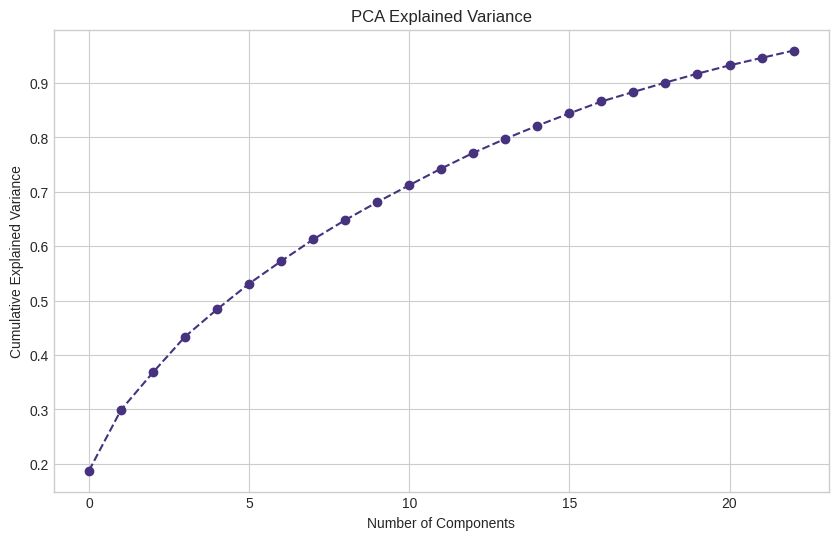

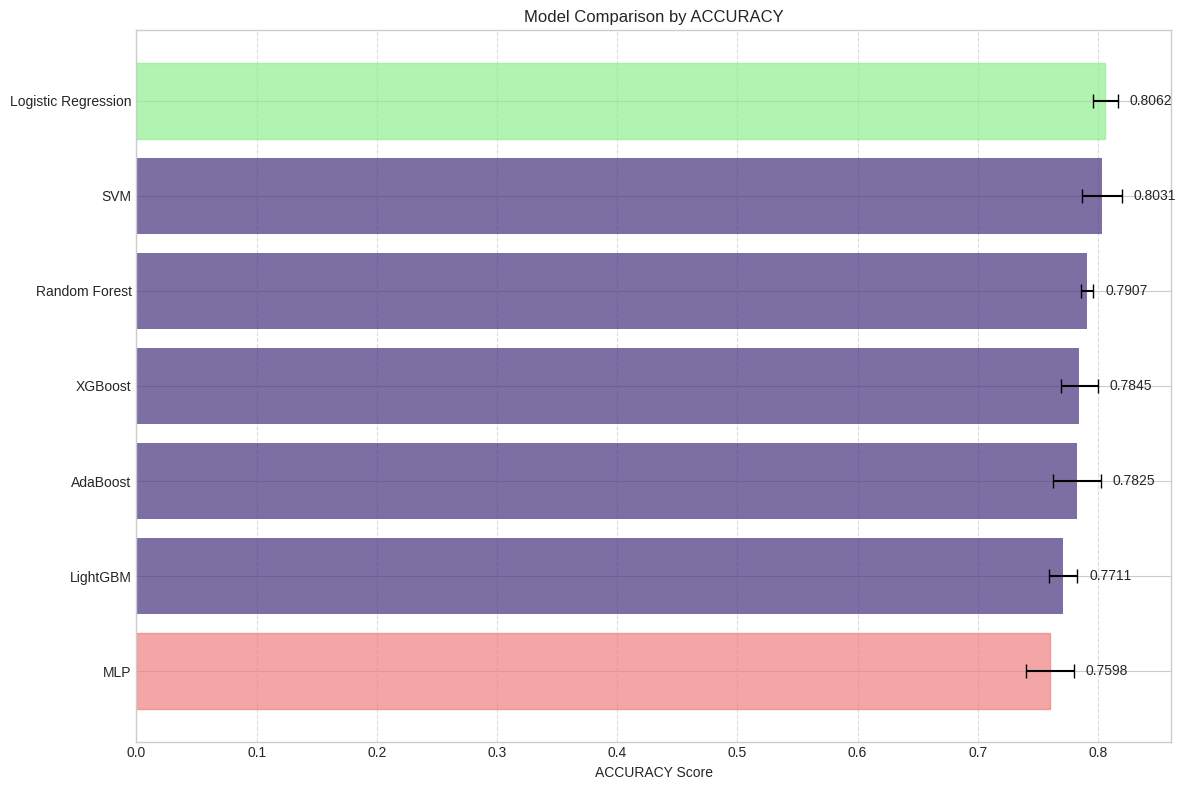

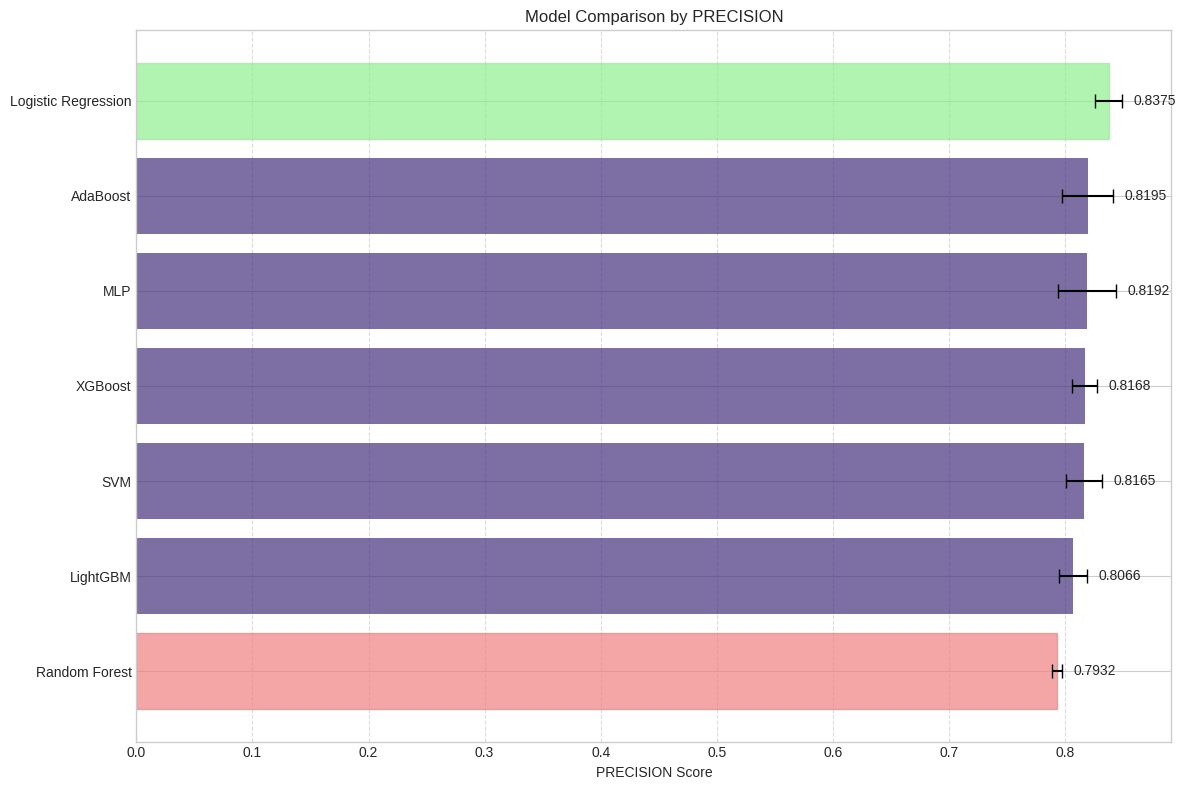

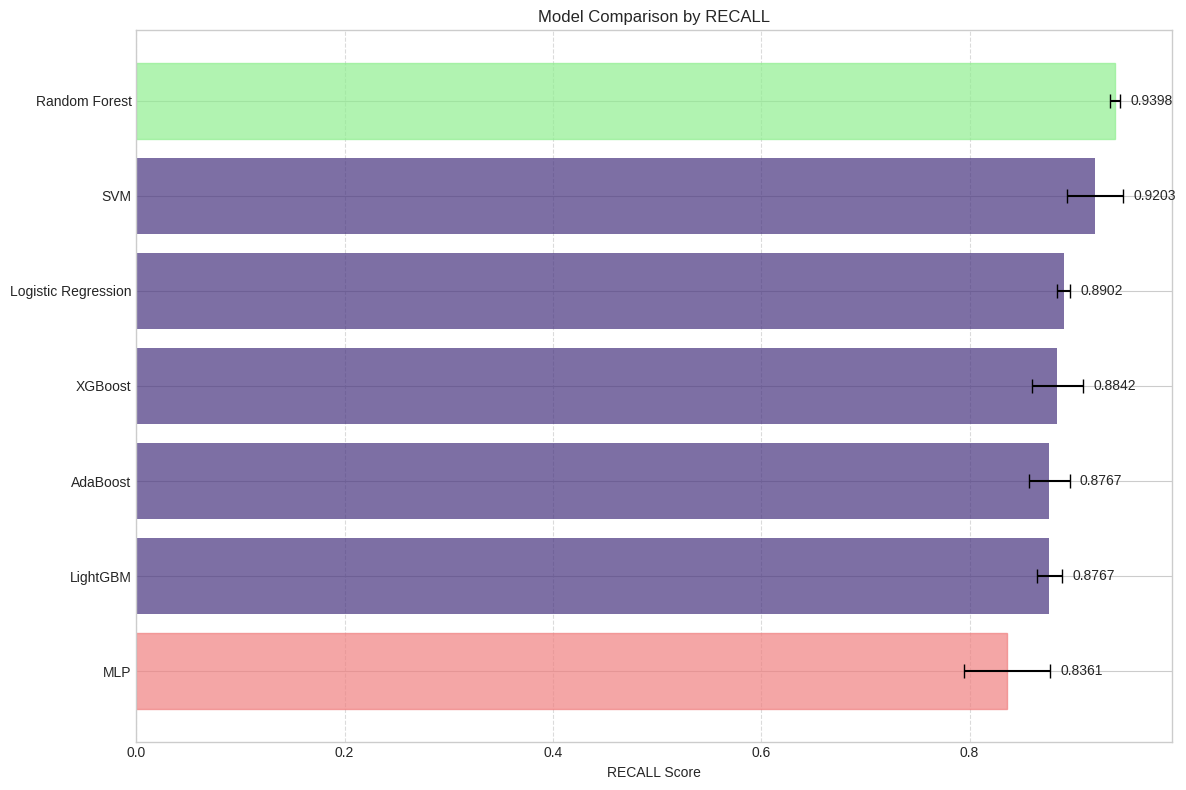

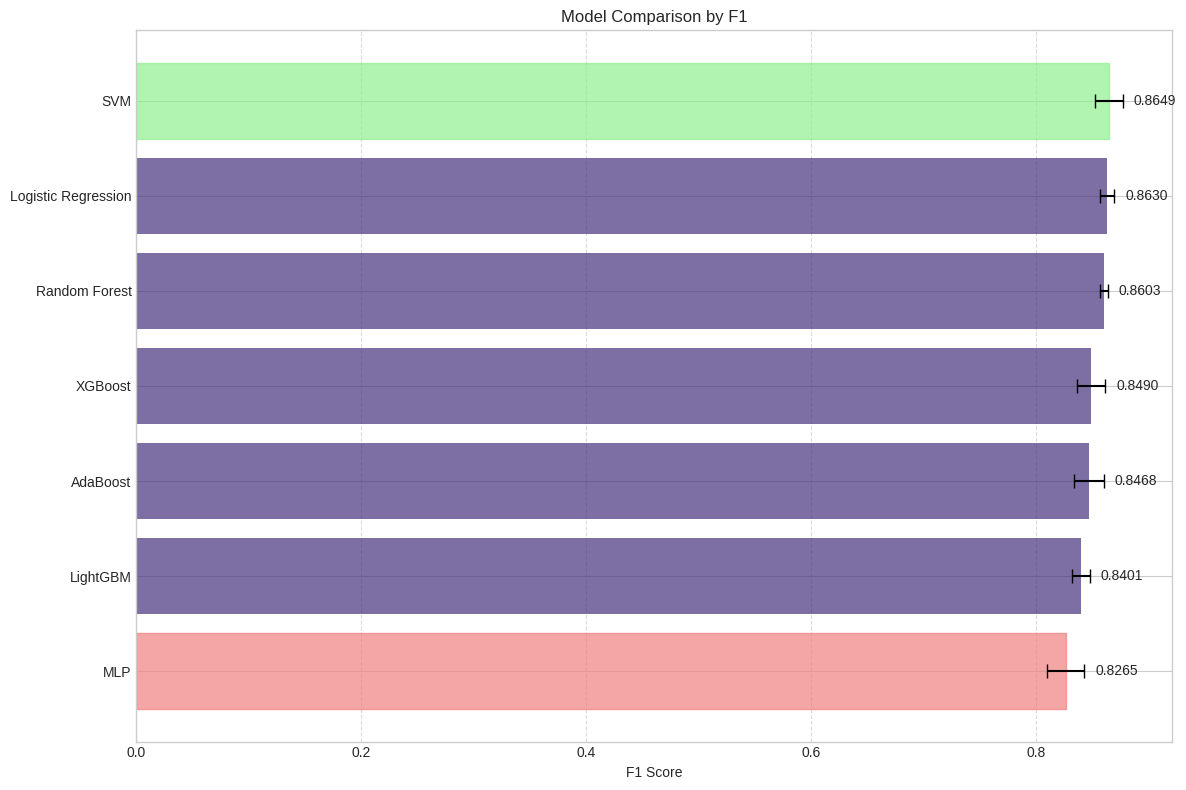

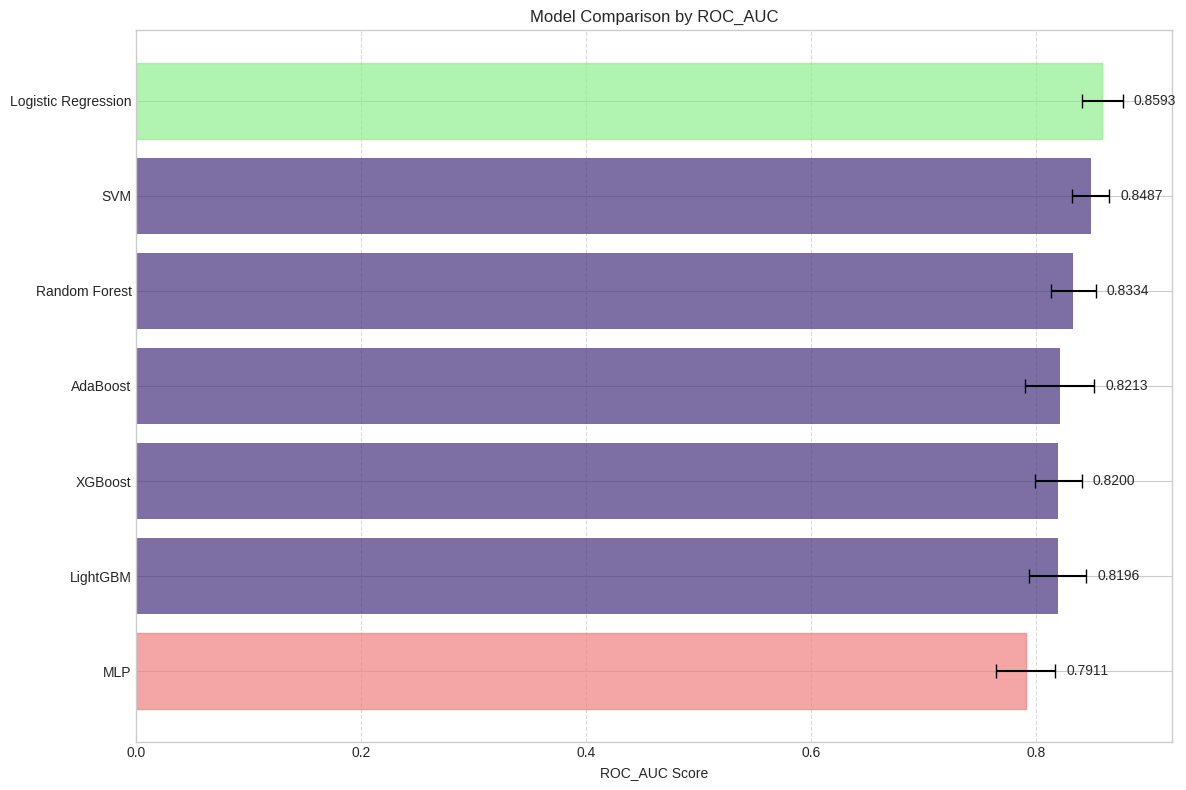

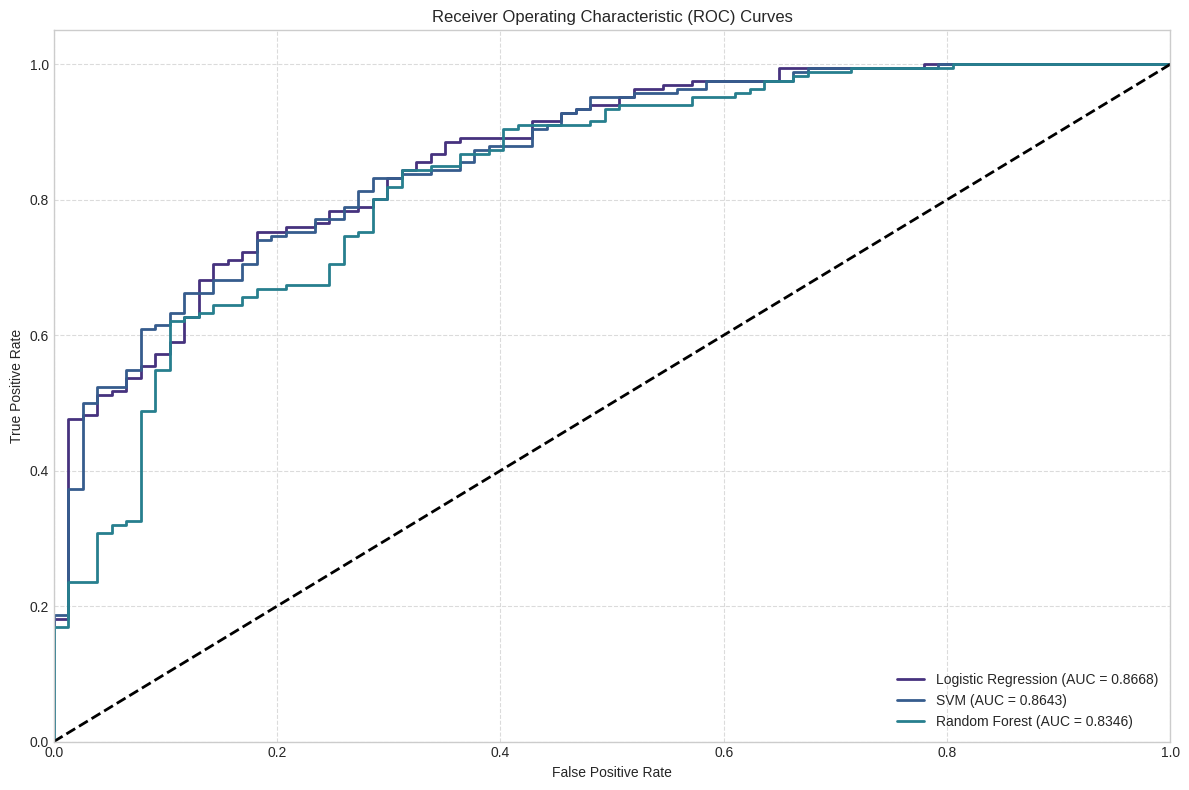

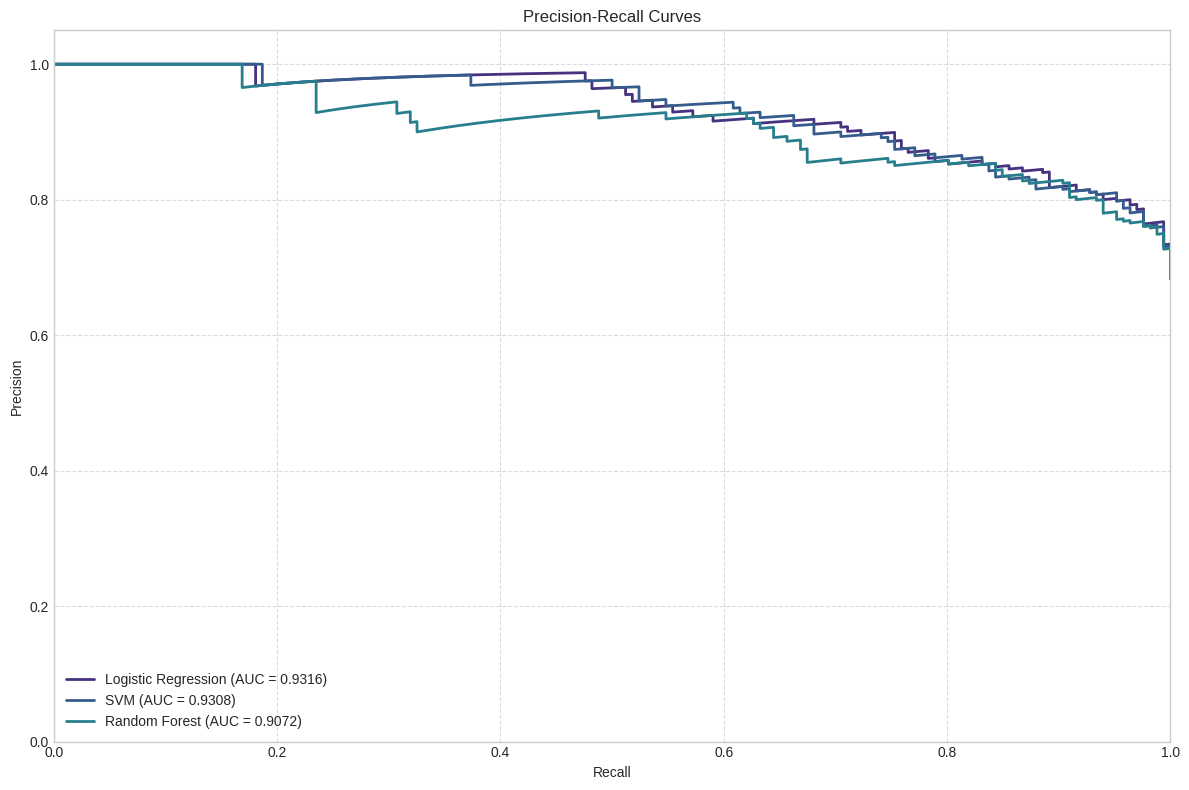

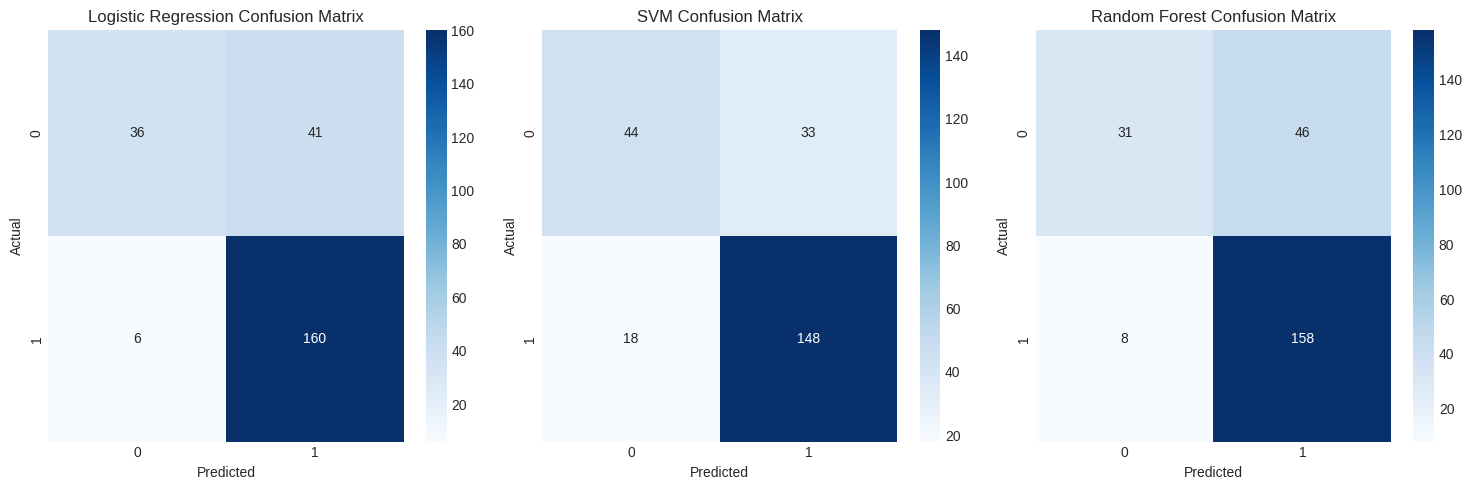

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

In [ ]:
# Main execution
if __name__ == "__main__":
    try:
        # Record start time
        start_time = time.time()

        print("="*80)
        print("ADHD CLASSIFICATION PIPELINE")
        print("="*80)

        # 1. Load data
        print("\nLoading data...")
        try:
            # Try to load data from standard location
            train = train
            test = test
            print(f"- Loaded training data: {train.shape}")
            print(f"- Loaded test data: {test.shape}")
        except FileNotFoundError:
            # Fallback to alternative location
            train = train
            test = test
            print(f"- Loaded training data from data/ directory: {train.shape}")
            print(f"- Loaded test data from data/ directory: {test.shape}")

        # 2. Feature Engineering
        train = feature_engineering(train)
        test = feature_engineering(test)

        # 3. Preprocess Data
        X, test_X, y, selected_features = preprocess_data(train, test, target_col="ADHD_Outcome")

        # 4. Apply PCA
        X_pca, test_X_pca, pca = apply_pca(X, test_X, min_variance=0.95)

        # 5. Split data into training and validation sets
        X_train, X_test, y_train, y_test = split_data(X_pca, y, test_size=0.2)

        # 6. Evaluate Models
        results = evaluate_models(X_train, y_train)

        # Plot model comparison
        for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']:
            plot_model_comparison(results, metric)

        # 7. Select top models for tuning based on ROC AUC
        top_models = sorted(
            [(name, results[name]['roc_auc']['mean']) for name in results],
            key=lambda x: x[1],
            reverse=True
        )[:3]  # Top 3 models

        models_to_tune = [name for name, _ in top_models]
        print(f"\nSelected top {len(models_to_tune)} models for tuning: {', '.join(models_to_tune)}")

        # 8. Tune hyperparameters
        tuned_models = tune_hyperparameters(X_train, y_train, models_to_tune)

        # 9. Evaluate tuned models on test set
        print("\nEvaluating tuned models on test set...")
        tuned_results = {}

        for name, model in tuned_models.items():
            # Make predictions
            y_pred = model.predict(X_test)
            y_score = model.predict_proba(X_test)[:, 1]

            # Calculate metrics
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            roc_auc = roc_auc_score(y_test, y_score)

            # Store results
            tuned_results[name] = {
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'roc_auc': roc_auc
            }

            # Print results
            print(f"\n{name} performance:")
            print(f"- Accuracy: {accuracy:.4f}")
            print(f"- Precision: {precision:.4f}")
            print(f"- Recall: {recall:.4f}")
            print(f"- F1 Score: {f1:.4f}")
            print(f"- ROC AUC: {roc_auc:.4f}")

            # Plot confusion matrix for this model
            cm = confusion_matrix(y_test, y_pred)
            plt.figure(figsize=(8, 6))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.title(f'{name} Confusion Matrix')
            plt.tight_layout()
            plt.savefig(f'plots/{name}_confusion_matrix.png', dpi=300, bbox_inches='tight')
            plt.close()

        # 10. Find best model
        best_model_name = max(tuned_results.items(), key=lambda x: x[1]['roc_auc'])[0]
        best_model = tuned_models[best_model_name]

        print(f"\nBest model: {best_model_name} (ROC AUC: {tuned_results[best_model_name]['roc_auc']:.4f})")

        # 11. Plot ROC and PR curves for tuned models
        plot_roc_curves(tuned_models, X_test, y_test)
        precision_recall_curves(tuned_models, X_test, y_test)

        # 12. Create confusion matrices
        create_confusion_matrices(tuned_models, X_test, y_test)

        # 13. Build ensemble model
        ensemble_model = build_ensemble_model(tuned_models, X_train, y_train)

        # Evaluate ensemble model on test set
        ensemble_pred = ensemble_model.predict(X_test)
        ensemble_score = ensemble_model.predict_proba(X_test)[:, 1]

        # Calculate metrics
        ensemble_accuracy = accuracy_score(y_test, ensemble_pred)
        ensemble_precision = precision_score(y_test, ensemble_pred)
        ensemble_recall = recall_score(y_test, ensemble_pred)
        ensemble_f1 = f1_score(y_test, ensemble_pred)
        ensemble_roc_auc = roc_auc_score(y_test, ensemble_score)

        # Print ensemble results
        print("\nEnsemble model performance on test set:")
        print(f"- Accuracy: {ensemble_accuracy:.4f}")
        print(f"- Precision: {ensemble_precision:.4f}")
        print(f"- Recall: {ensemble_recall:.4f}")
        print(f"- F1 Score: {ensemble_f1:.4f}")
        print(f"- ROC AUC: {ensemble_roc_auc:.4f}")

        # Plot ensemble confusion matrix
        ensemble_cm = confusion_matrix(y_test, ensemble_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(ensemble_cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Ensemble Model Confusion Matrix')
        plt.tight_layout()
        plt.savefig('plots/ensemble_confusion_matrix.png', dpi=300, bbox_inches='tight')
        plt.close()

        # Compare ensemble with best individual model
        print("\nComparing ensemble model with best individual model:")
        print(f"- Best individual model ({best_model_name}) ROC AUC: {tuned_results[best_model_name]['roc_auc']:.4f}")
        print(f"- Ensemble model ROC AUC: {ensemble_roc_auc:.4f}")

        # Choose the final model (best individual or ensemble)
        final_model = ensemble_model if ensemble_roc_auc > tuned_results[best_model_name]['roc_auc'] else best_model
        final_model_name = "Ensemble" if ensemble_roc_auc > tuned_results[best_model_name]['roc_auc'] else best_model_name

        print(f"\nFinal model selected: {final_model_name}")

        # 14. Interpret the final model
        try:
            # If we have PCA, generate feature names as PC1, PC2, etc.
            if 'pca' in locals():
                pca_feature_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
                interpret_model(final_model, X_pca, pca_feature_names)
            else:
                interpret_model(final_model, X, selected_features)
        except Exception as e:
            print(f"Error interpreting model: {str(e)}")

        # 15. Generate submission file using the final model
        # Retrain on full dataset
        print("\nRetraining final model on full dataset...")
        if final_model == ensemble_model:
            # Rebuild ensemble with full data
            final_model = build_ensemble_model(tuned_models, X_pca, y)
        else:
            # Retrain best individual model
            final_model.fit(X_pca, y)

        # Generate submission
        generate_submission_file(final_model, test_X_pca, test, output_file="ADHD_prediction_submission.csv")

        # 16. Print summary report
        runtime = time.time() - start_time
        print_summary_report(results, best_model_name, tuned_models, ensemble_model, runtime)

    except Exception as e:
        print(f"\nERROR: {str(e)}")
        import traceback
        traceback.print_exc()